# Table of Contents

- Prompt
- Initial Thoughts
- Data Preprocessing
- Feature Engineering
- EDA
- Modeling
- Future Work

# Prompt

Attached here is a link to zip containing a data file containing all pitches from the 2011 MLB season and the associated metadata describing the data.

Please review the dataset and start outlining the way you would go about the model-building process with the goal of predicting the probability that the next thrown pitch will be a fastball, slider, change-up, etc.

We would like to see you assess the data, build a predictive model, and then evaluate that model and the success of its predictions,  with the understanding that delivering predictions with any degree of accuracy is unlikely in this short time span. Please provide any associated data analysis (plots, graphs, etc..), feature engineering, and code assembled in the form of a python notebook (or similar). Please include markup text to explain your analysis, graphs, etc. If you include a notebook, please also add an HTML version of that notebook, to facilitate review.

We would like you to spend no more than 4-6 hours on this project so please provide some details around future steps you would take if you had more time to finalize this project.  This is meant to be an open-ended/creative project, so focus your time where you see best.

# Initial Thoughts

I spoke with a friend who used to pitch in the Minors to get his input on factors he considers when throwing his next pitch. Using his input and the features available, below are the features I considered to predict the probability of the next pitch. The features are grouped into four categories:
- temporal
  - as the season progresses, players may experience fatigue impacting a pitcher's ability to throw certain pitches effectively, opting for pitches that are less straining.
- game
  - pitchers often adjust their strategies based on the game context
  - e.g. large deficet => more nerves. large lead => less nerves
  - e.g. in a close game, pitchers may be more cautious and focus on hitting the strike zone to avoid giving up runs.
- at-bat
  - pitchers often adjust their strategies based on the current at-bat
  - e.g. if the count is in favor of the batter, pitchers may be more likely to pitch in the strike zone to avoid walking the batter (i.e. more fastballs).
  - e.g. if the count is in favor of the pitcher, pitchers may be more likely to pick off-speed or breaking pitches to get the batter swinging out of the strike zone.
  - e.g. if a batter is fouling, it can indicate they are timing pitcher's throws so, a pitcher may throw a change-up.
  - e.g. if there's two outs with no runnners on base, pitchers may be more aggressive and less concerned with walks (i.e. harder pitches but higher risk of being out of the strike zone).
- batter
  - knowing a batter's strengths (e.g. hitting fastballs) and weaknesses (e.g. struggling against breaking balls) can provide insights.
- pitcher
  - a diverse repertoire may make it more challenging for batters.

## features
### predictor
- pitch_type

### temporal
- game number

### game
- inning
- top
  - knowing whether a pitching in the bottom vs. top indicates whether or not a pitcher has at-home advantage.
- score differential

### at-bat
- pcount_at_bat
- pcount_pitcher
- balls
- strikes
- fouls
- outs
- on_1b
- on_2b
- on_3b
- _pitch_sequence_
  - the previous three pitch types and results were appended to account for their influence on the pitcher's strategy.
  - e.g. throwing an off-speed pitch after a fastball.

### batter
- batter_id
- stand
- b_height
- _batter's performance_
  - SLG
  - OBP
    - Batters with higher OBP tend to be more patient at the plate and less likely to chase pitches outside the strike zone.

### pitcher
- pitcher_id
- p_throws
- _pitcher's performance_
  - weighting of pitcher's favorable pitches.
  - ERA
    - indicator of a pitcher's consistency.
  - Strikeout Rate
    - indicator of a pitcher's dominance to miss bats.
  - Walk Rate
    - high walk rates may lead pitchers to be more cautious and use certain pitches to avoid walks.
  - WHIP
    - indicator of a pitcher's control to keep opposing hitters off base.

In [239]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from warnings import filterwarnings
filterwarnings('ignore')

import os
os.chdir('/Users/patchong/Google Drive/My Drive/Work/Prep/Challenges/Swish Analytics')

In [240]:
pitches = pd.read_csv('pitches.csv', low_memory=False)

# Data Preprocessing

In [241]:
print('Shape: {0}'.format(pitches.shape))

Shape: (718961, 125)


In [242]:
pitches.head()

,uid,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,is_final_pitch,final_balls,final_strikes,final_outs,start_tfs,start_tfs_zulu,batter_id,stand,b_height,pitcher_id,p_throws,at_bat_des,event,event2,event3,event4,away_team_runs,home_team_runs,score,pitch_des,pitch_id,type,pitch_tfs,pitch_tfs_zulu,x,y,sv_id,start_speed,end_speed,sz_top,sz_bot,pfx_x,pfx_z,px,pz,x0,z0,y0,vx0,vz0,vy0,ax,az,ay,break_length,break_y,break_angle,pitch_type,type_confidence,zone,nasty,spin_dir,spin_rate,cc,on_1b,on_2b,on_3b,runner1_id,runner1_start,runner1_end,runner1_event,runner1_score,runner1_rbi,runner1_earned,runner2_id,runner2_start,runner2_end,runner2_event,runner2_score,runner2_rbi,runner2_earned,runner3_id,runner3_start,runner3_end,runner3_event,runner3_score,runner3_rbi,runner3_earned,runner4_id,runner4_start,runner4_end,runner4_event,runner4_score,runner4_rbi,runner4_earned,runner5_id,runner5_start,runner5_end,runner5_event,runner5_score,runner5_rbi,runner5_earned,runner6_id,runner6_start,runner6_end,runner6_event,runner6_score,runner6_rbi,runner6_earned,runner7_id,runner7_start,runner7_end,runner7_event,runner7_score,runner7_rbi,runner7_earned,created_at,added_at,modified_at,modified_by
0,14143226,286874,2011,2011-03-31,108,118,1,1,1,1,1,0,0,0,0,0,2,1,1,201226,2011-03-31 20:12:26,430895,L,5-8,460024,R,Maicer Izturis g...,Groundout,NaN,NaN,NaN,0,0,NaN,Ball,3,B,201301.0,2011-03-31 20:13:01,105.58,180.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 21:33:20,2016-03-03 21:33:20,2016-03-03 21:33:20,1
1,14143227,286874,2011,2011-03-31,108,118,1,1,1,2,2,1,0,0,0,0,2,1,1,201226,2011-03-31 20:12:26,430895,L,5-8,460024,R,Maicer Izturis g...,Groundout,NaN,NaN,NaN,0,0,NaN,Ball,4,B,201319.0,2011-03-31 20:13:19,99.57,170.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 21:33:20,2016-03-03 21:33:20,2016-03-03 21:33:20,1
2,14143228,286874,2011,2011-03-31,108,118,1,1,1,3,3,2,0,0,0,0,2,1,1,201226,2011-03-31 20:12:26,430895,L,5-8,460024,R,Maicer Izturis g...,Groundout,NaN,NaN,NaN,0,0,NaN,Called Strike,5,S,201327.0,2011-03-31 20:13:27,95.28,152.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 21:33:20,2016-03-03 21:33:20,2016-03-03 21:33:20,1
3,14143229,286874,2011,2011-03-31,108,118,1,1,1,4,4,2,1,0,0,1,2,1,1,201226,2011-03-31 20:12:26,430895,L,5-8,460024,R,Maicer Izturis g...,Groundout,NaN,NaN,NaN,0,0,NaN,"In play, out(s)",6,X,180441.0,2011-03-31 18:04:41,93.56,168.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 21:33:20,2016-03-03 21:33:20,2016-03-03 21:33:20,1
4,14143230,286874,2011,2011-03-31,108,118,1,1,2,1,5,0,0,0,1,0,2,2,1,201354,2011-03-31 20:13:54,435062,R,5-10,460024,R,Howie Kendrick d...,Double,NaN,NaN,NaN,0,0,NaN,Called Strike,10,S,201404.0,2011-03-31 20:14:04,99.57,170.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [243]:
output = []

for col in pitches.columns:

    null = pitches[col].isnull().sum()
    unique = pitches[col].nunique()
    colType = str(pitches[col].dtype)

    output.append([col, null, unique, colType])

output = pd.DataFrame(output)   
output.columns = ['colName','null values', 'unique', 'dtype']
output

,colName,null values,unique,dtype
0,uid,0,718961,int64
1,game_pk,0,2467,int64
2,year,0,1,int64
3,date,0,203,object
4,team_id_b,0,30,int64
5,team_id_p,0,30,int64
6,inning,0,19,int64
7,top,0,2,int64
8,at_bat_num,0,158,int64
9,pcount_at_bat,0,16,int64


In [244]:
pitches = pitches[pitches.columns.drop(list(pitches.filter(regex='runner')))]

# Feature Engineering

In [245]:
# shit = df[df.game_pk == 287092]
# shit = shit[shit.batter_id == 408108]
# shit = shit[shit.pitcher_id == 430912]
# shit = shit[shit.top == 1]
df = pitches[[
    'game_pk'
    , 'year'
    , 'date'
    , 'team_id_b'
    , 'team_id_p'
    , 'inning'
    , 'top'
    , 'at_bat_num'
    , 'pcount_at_bat'
    , 'pcount_pitcher'
    , 'balls'
    , 'strikes'
    , 'fouls'
    , 'outs'
    , 'final_balls'
    , 'final_strikes'
    , 'batter_id'
    , 'stand'
    , 'b_height'
    , 'pitcher_id'
    , 'p_throws'
    , 'away_team_runs'
    , 'home_team_runs'
    , 'on_1b'
    , 'on_2b'
    , 'on_3b'
    , 'is_final_pitch'
    , 'event'
    , 'type'
    , 'pitch_type'
]]

In [246]:
df.head()

,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,final_balls,final_strikes,batter_id,stand,b_height,pitcher_id,p_throws,away_team_runs,home_team_runs,on_1b,on_2b,on_3b,is_final_pitch,event,type,pitch_type
0,286874,2011,2011-03-31,108,118,1,1,1,1,1,0,0,0,0,2,1,430895,L,5-8,460024,R,0,0,NaN,NaN,NaN,0,Groundout,B,NaN
1,286874,2011,2011-03-31,108,118,1,1,1,2,2,1,0,0,0,2,1,430895,L,5-8,460024,R,0,0,NaN,NaN,NaN,0,Groundout,B,NaN
2,286874,2011,2011-03-31,108,118,1,1,1,3,3,2,0,0,0,2,1,430895,L,5-8,460024,R,0,0,NaN,NaN,NaN,0,Groundout,S,NaN
3,286874,2011,2011-03-31,108,118,1,1,1,4,4,2,1,0,0,2,1,430895,L,5-8,460024,R,0,0,NaN,NaN,NaN,1,Groundout,X,NaN
4,286874,2011,2011-03-31,108,118,1,1,2,1,5,0,0,0,1,2,2,435062,R,5-10,460024,R,0,0,NaN,NaN,NaN,0,Double,S,NaN


## pitcher game number

In [247]:
# Sort the DataFrame by 'pitcher_id' and 'date'
df.sort_values(by=['pitcher_id', 'date'], inplace=True)

# Calculate the game number for each pitcher based on date and assign the same rank to duplicates
df['game_number_for_pitcher'] = df.groupby('pitcher_id')['date'].rank(method='dense', ascending=True).astype(int)

In [248]:
df.head()

,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,final_balls,final_strikes,batter_id,stand,b_height,pitcher_id,p_throws,away_team_runs,home_team_runs,on_1b,on_2b,on_3b,is_final_pitch,event,type,pitch_type,game_number_for_pitcher
1415,286878,2011,2011-03-31,135,138,8,1,55,1,1,0,0,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,0,Groundout,B,SI,1
1416,286878,2011,2011-03-31,135,138,8,1,55,2,2,1,0,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,0,Groundout,B,SI,1
1417,286878,2011,2011-03-31,135,138,8,1,55,3,3,2,0,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,0,Groundout,S,SI,1
1418,286878,2011,2011-03-31,135,138,8,1,55,4,4,2,1,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,1,Groundout,X,SI,1
1419,286878,2011,2011-03-31,135,138,8,1,56,1,5,0,0,0,1,1,0,408305,R,6-3,110683,R,2,2,NaN,NaN,NaN,0,Single,B,SI,1


## batter stance

In [249]:
# One-hot encode batter stance 
batter_right_handed = pd.get_dummies(df['stand'], drop_first = True)

# Add the one-hot encoded pitch types to the original DataFrame
df = pd.concat([df, batter_right_handed], axis=1)
df.rename(columns={'R': 'batter_right_handed'}, inplace=True)

In [250]:
df.head()

,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,final_balls,final_strikes,batter_id,stand,b_height,pitcher_id,p_throws,away_team_runs,home_team_runs,on_1b,on_2b,on_3b,is_final_pitch,event,type,pitch_type,game_number_for_pitcher,batter_right_handed
1415,286878,2011,2011-03-31,135,138,8,1,55,1,1,0,0,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,0,Groundout,B,SI,1,1
1416,286878,2011,2011-03-31,135,138,8,1,55,2,2,1,0,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,0,Groundout,B,SI,1,1
1417,286878,2011,2011-03-31,135,138,8,1,55,3,3,2,0,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,0,Groundout,S,SI,1,1
1418,286878,2011,2011-03-31,135,138,8,1,55,4,4,2,1,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,1,Groundout,X,SI,1,1
1419,286878,2011,2011-03-31,135,138,8,1,56,1,5,0,0,0,1,1,0,408305,R,6-3,110683,R,2,2,NaN,NaN,NaN,0,Single,B,SI,1,1


## batter height

In [251]:
# Apply a lambda function to convert 'batter_height' to total inches
df['batter_height_inches'] = df['b_height'].apply(lambda x: int(x.split('-')[0]) * 12 + int(x.split('-')[1]))

In [252]:
df.head()

,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,final_balls,final_strikes,batter_id,stand,b_height,pitcher_id,p_throws,away_team_runs,home_team_runs,on_1b,on_2b,on_3b,is_final_pitch,event,type,pitch_type,game_number_for_pitcher,batter_right_handed,batter_height_inches
1415,286878,2011,2011-03-31,135,138,8,1,55,1,1,0,0,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,0,Groundout,B,SI,1,1,73
1416,286878,2011,2011-03-31,135,138,8,1,55,2,2,1,0,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,0,Groundout,B,SI,1,1,73
1417,286878,2011,2011-03-31,135,138,8,1,55,3,3,2,0,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,0,Groundout,S,SI,1,1,73
1418,286878,2011,2011-03-31,135,138,8,1,55,4,4,2,1,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,1,Groundout,X,SI,1,1,73
1419,286878,2011,2011-03-31,135,138,8,1,56,1,5,0,0,0,1,1,0,408305,R,6-3,110683,R,2,2,NaN,NaN,NaN,0,Single,B,SI,1,1,75


## pitcher stance

In [253]:
# One-hot encode pitcher hand
pitcher_right_handed = pd.get_dummies(df['p_throws'], drop_first = False)

# Add the one-hot encoded pitch types to the original DataFrame
df = pd.concat([df, pitcher_right_handed], axis=1)
df.rename(columns={'R': 'pitcher_right_handed'}, inplace=True)

In [254]:
df.head()

,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,final_balls,final_strikes,batter_id,stand,b_height,pitcher_id,p_throws,away_team_runs,home_team_runs,on_1b,on_2b,on_3b,is_final_pitch,event,type,pitch_type,game_number_for_pitcher,batter_right_handed,batter_height_inches,L,pitcher_right_handed
1415,286878,2011,2011-03-31,135,138,8,1,55,1,1,0,0,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,0,Groundout,B,SI,1,1,73,0,1
1416,286878,2011,2011-03-31,135,138,8,1,55,2,2,1,0,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,0,Groundout,B,SI,1,1,73,0,1
1417,286878,2011,2011-03-31,135,138,8,1,55,3,3,2,0,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,0,Groundout,S,SI,1,1,73,0,1
1418,286878,2011,2011-03-31,135,138,8,1,55,4,4,2,1,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,1,Groundout,X,SI,1,1,73,0,1
1419,286878,2011,2011-03-31,135,138,8,1,56,1,5,0,0,0,1,1,0,408305,R,6-3,110683,R,2,2,NaN,NaN,NaN,0,Single,B,SI,1,1,75,0,1


## score differential

In [255]:
# Calculate run differential based on pitcher.
df['score_differential'] = df.apply(lambda row: row['home_team_runs'] - row['away_team_runs'] if row['top'] == 1 else row['away_team_runs'] - row['home_team_runs'], axis=1)

In [256]:
df.head()

,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,final_balls,final_strikes,batter_id,stand,b_height,pitcher_id,p_throws,away_team_runs,home_team_runs,on_1b,on_2b,on_3b,is_final_pitch,event,type,pitch_type,game_number_for_pitcher,batter_right_handed,batter_height_inches,L,pitcher_right_handed,score_differential
1415,286878,2011,2011-03-31,135,138,8,1,55,1,1,0,0,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,0,Groundout,B,SI,1,1,73,0,1,0
1416,286878,2011,2011-03-31,135,138,8,1,55,2,2,1,0,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,0,Groundout,B,SI,1,1,73,0,1,0
1417,286878,2011,2011-03-31,135,138,8,1,55,3,3,2,0,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,0,Groundout,S,SI,1,1,73,0,1,0
1418,286878,2011,2011-03-31,135,138,8,1,55,4,4,2,1,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,1,Groundout,X,SI,1,1,73,0,1,0
1419,286878,2011,2011-03-31,135,138,8,1,56,1,5,0,0,0,1,1,0,408305,R,6-3,110683,R,2,2,NaN,NaN,NaN,0,Single,B,SI,1,1,75,0,1,0


## base runners

In [257]:
# One-hot encode 'on_*b' since we only have one season of data
# Don't drop_first since all 0's could be ambigious. (i.e. are bases empty or bases loaded?)
df['is_first_base_occupied'] = (df['on_1b'].notna()).astype(int)
df['is_second_base_occupied'] = (df['on_2b'].notna()).astype(int)
df['is_third_base_occupied'] = (df['on_3b'].notna()).astype(int)

In [258]:
df.head()

,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,final_balls,final_strikes,batter_id,stand,b_height,pitcher_id,p_throws,away_team_runs,home_team_runs,on_1b,on_2b,on_3b,is_final_pitch,event,type,pitch_type,game_number_for_pitcher,batter_right_handed,batter_height_inches,L,pitcher_right_handed,score_differential,is_first_base_occupied,is_second_base_occupied,is_third_base_occupied
1415,286878,2011,2011-03-31,135,138,8,1,55,1,1,0,0,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,0,Groundout,B,SI,1,1,73,0,1,0,0,0,0
1416,286878,2011,2011-03-31,135,138,8,1,55,2,2,1,0,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,0,Groundout,B,SI,1,1,73,0,1,0,0,0,0
1417,286878,2011,2011-03-31,135,138,8,1,55,3,3,2,0,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,0,Groundout,S,SI,1,1,73,0,1,0,0,0,0
1418,286878,2011,2011-03-31,135,138,8,1,55,4,4,2,1,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,1,Groundout,X,SI,1,1,73,0,1,0,0,0,0
1419,286878,2011,2011-03-31,135,138,8,1,56,1,5,0,0,0,1,1,0,408305,R,6-3,110683,R,2,2,NaN,NaN,NaN,0,Single,B,SI,1,1,75,0,1,0,0,0,0


## starting vs. reliever pitcher?

In [259]:
df['starting_pitcher'] = df.groupby(['game_pk', 'pitcher_id'])['inning'].transform(lambda x: 1 if x.min() == 1 else 0)

In [260]:
df.head()

,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,final_balls,final_strikes,batter_id,stand,b_height,pitcher_id,p_throws,away_team_runs,home_team_runs,on_1b,on_2b,on_3b,is_final_pitch,event,type,pitch_type,game_number_for_pitcher,batter_right_handed,batter_height_inches,L,pitcher_right_handed,score_differential,is_first_base_occupied,is_second_base_occupied,is_third_base_occupied,starting_pitcher
1415,286878,2011,2011-03-31,135,138,8,1,55,1,1,0,0,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,0,Groundout,B,SI,1,1,73,0,1,0,0,0,0,0
1416,286878,2011,2011-03-31,135,138,8,1,55,2,2,1,0,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,0,Groundout,B,SI,1,1,73,0,1,0,0,0,0,0
1417,286878,2011,2011-03-31,135,138,8,1,55,3,3,2,0,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,0,Groundout,S,SI,1,1,73,0,1,0,0,0,0,0
1418,286878,2011,2011-03-31,135,138,8,1,55,4,4,2,1,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,1,Groundout,X,SI,1,1,73,0,1,0,0,0,0,0
1419,286878,2011,2011-03-31,135,138,8,1,56,1,5,0,0,0,1,1,0,408305,R,6-3,110683,R,2,2,NaN,NaN,NaN,0,Single,B,SI,1,1,75,0,1,0,0,0,0,0


## batter and pitcher faceoff

In [261]:
df['pitcher_vs_batter_count'] = (df.groupby(['pitcher_id', 'batter_id']).cumcount())

In [262]:
df.head()

,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,final_balls,final_strikes,batter_id,stand,b_height,pitcher_id,p_throws,away_team_runs,home_team_runs,on_1b,on_2b,on_3b,is_final_pitch,event,type,pitch_type,game_number_for_pitcher,batter_right_handed,batter_height_inches,L,pitcher_right_handed,score_differential,is_first_base_occupied,is_second_base_occupied,is_third_base_occupied,starting_pitcher,pitcher_vs_batter_count
1415,286878,2011,2011-03-31,135,138,8,1,55,1,1,0,0,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,0,Groundout,B,SI,1,1,73,0,1,0,0,0,0,0,0
1416,286878,2011,2011-03-31,135,138,8,1,55,2,2,1,0,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,0,Groundout,B,SI,1,1,73,0,1,0,0,0,0,0,1
1417,286878,2011,2011-03-31,135,138,8,1,55,3,3,2,0,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,0,Groundout,S,SI,1,1,73,0,1,0,0,0,0,0,2
1418,286878,2011,2011-03-31,135,138,8,1,55,4,4,2,1,0,0,2,1,460026,R,6-1,110683,R,2,2,NaN,NaN,NaN,1,Groundout,X,SI,1,1,73,0,1,0,0,0,0,0,3
1419,286878,2011,2011-03-31,135,138,8,1,56,1,5,0,0,0,1,1,0,408305,R,6-3,110683,R,2,2,NaN,NaN,NaN,0,Single,B,SI,1,1,75,0,1,0,0,0,0,0,0


## pitch sequence
### pitch type

In [263]:
# One-hot encode 'pitch_type'
# Don't drop_first since all 0's could be ambigious (i.e. is it a type of pitch or have no pitches been thrown?)
pitch_type_encoded = pd.get_dummies(df['pitch_type'], prefix='pitch_type', drop_first = False)

# Add the one-hot encoded pitch types to the original DataFrame
df = pd.concat([df, pitch_type_encoded], axis=1)

# Create a list of pitch type columns
pitch_type_columns = pitch_type_encoded.columns

# Create columns for the previous 3 pitches for each pitch type
for i in range(1, 4):
    for col in pitch_type_columns:
        df[f'prev_{i}_{col}'] = df.groupby(['game_pk', 'pitcher_id', 'at_bat_num'])[col].shift(i)

# Fill NaN values with 0 for the newly created columns
df.fillna(0, inplace=True)

In [264]:
df.head()

,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,final_balls,final_strikes,batter_id,stand,b_height,pitcher_id,p_throws,away_team_runs,home_team_runs,on_1b,on_2b,on_3b,is_final_pitch,event,type,pitch_type,game_number_for_pitcher,batter_right_handed,batter_height_inches,L,pitcher_right_handed,score_differential,is_first_base_occupied,is_second_base_occupied,is_third_base_occupied,starting_pitcher,pitcher_vs_batter_count,pitch_type_AB,pitch_type_CH,pitch_type_CU,pitch_type_EP,pitch_type_FA,pitch_type_FC,pitch_type_FF,pitch_type_FO,pitch_type_FS,pitch_type_FT,pitch_type_IN,pitch_type_KC,pitch_type_KN,pitch_type_PO,pitch_type_SC,pitch_type_SI,pitch_type_SL,pitch_type_UN,prev_1_pitch_type_AB,prev_1_pitch_type_CH,prev_1_pitch_type_CU,prev_1_pitch_type_EP,prev_1_pitch_type_FA,prev_1_pitch_type_FC,prev_1_pitch_type_FF,prev_1_pitch_type_FO,prev_1_pitch_type_FS,prev_1_pitch_type_FT,prev_1_pitch_type_IN,prev_1_pitch_type_KC,prev_1_pitch_type_KN,prev_1_pitch_type_PO,prev_1_pitch_type_SC,prev_1_pitch_type_SI,prev_1_pitch_type_SL,prev_1_pitch_type_UN,prev_2_pitch_type_AB,prev_2_pitch_type_CH,prev_2_pitch_type_CU,prev_2_pitch_type_EP,prev_2_pitch_type_FA,prev_2_pitch_type_FC,prev_2_pitch_type_FF,prev_2_pitch_type_FO,prev_2_pitch_type_FS,prev_2_pitch_type_FT,prev_2_pitch_type_IN,prev_2_pitch_type_KC,prev_2_pitch_type_KN,prev_2_pitch_type_PO,prev_2_pitch_type_SC,prev_2_pitch_type_SI,prev_2_pitch_type_SL,prev_2_pitch_type_UN,prev_3_pitch_type_AB,prev_3_pitch_type_CH,prev_3_pitch_type_CU,prev_3_pitch_type_EP,prev_3_pitch_type_FA,prev_3_pitch_type_FC,prev_3_pitch_type_FF,prev_3_pitch_type_FO,prev_3_pitch_type_FS,prev_3_pitch_type_FT,prev_3_pitch_type_IN,prev_3_pitch_type_KC,prev_3_pitch_type_KN,prev_3_pitch_type_PO,prev_3_pitch_type_SC,prev_3_pitch_type_SI,prev_3_pitch_type_SL,prev_3_pitch_type_UN
1415,286878,2011,2011-03-31,135,138,8,1,55,1,1,0,0,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0,0,Groundout,B,SI,1,1,73,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1416,286878,2011,2011-03-31,135,138,8,1,55,2,2,1,0,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0,0,Groundout,B,SI,1,1,73,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1417,286878,2011,2011-03-31,135,138,8,1,55,3,3,2,0,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0,0,Groundout,S,SI,1,1,73,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1418,286878,2011,2011-03-31,135,138,8,1,55,4,4,2,1,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0,1,Groundout,X,SI,1,1,73,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1419,286878,2011,2011-03-31,135,138,8,1,56,1,5,0,0,0,1,1,0,408305,R,6-3,110683,R,2,2,0.0,0.0,0.0,0,Single,B,SI,1,1,75,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### pitch result

In [265]:
# One-hot encode 'type'
# Don't drop_first since all 0's could be ambigious.
pitch_result_encoded = pd.get_dummies(df['type'], prefix='pitch_result', drop_first = False)

# Add the one-hot encoded pitch types to the original DataFrame
df = pd.concat([df, pitch_result_encoded], axis=1)

# Create a list of pitch type columns
pitch_result_columns = pitch_result_encoded.columns

# Create columns for the previous 3 pitches for each pitch type, pitcher, and at_bat
for i in range(1, 4):
    for col in pitch_result_columns:
        df[f'prev_{i}_{col}'] = df.groupby(['game_pk', 'pitcher_id', 'at_bat_num'])[col].shift(i)

# Fill NaN values with 0 for the newly created columns
df.fillna(0, inplace=True)

In [266]:
df.head()

,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,final_balls,final_strikes,batter_id,stand,b_height,pitcher_id,p_throws,away_team_runs,home_team_runs,on_1b,on_2b,on_3b,is_final_pitch,event,type,pitch_type,game_number_for_pitcher,batter_right_handed,batter_height_inches,L,pitcher_right_handed,score_differential,is_first_base_occupied,is_second_base_occupied,is_third_base_occupied,starting_pitcher,pitcher_vs_batter_count,pitch_type_AB,pitch_type_CH,pitch_type_CU,pitch_type_EP,pitch_type_FA,pitch_type_FC,pitch_type_FF,pitch_type_FO,pitch_type_FS,pitch_type_FT,pitch_type_IN,pitch_type_KC,pitch_type_KN,pitch_type_PO,pitch_type_SC,pitch_type_SI,pitch_type_SL,pitch_type_UN,prev_1_pitch_type_AB,prev_1_pitch_type_CH,prev_1_pitch_type_CU,prev_1_pitch_type_EP,prev_1_pitch_type_FA,prev_1_pitch_type_FC,prev_1_pitch_type_FF,prev_1_pitch_type_FO,prev_1_pitch_type_FS,prev_1_pitch_type_FT,prev_1_pitch_type_IN,prev_1_pitch_type_KC,prev_1_pitch_type_KN,prev_1_pitch_type_PO,prev_1_pitch_type_SC,prev_1_pitch_type_SI,prev_1_pitch_type_SL,prev_1_pitch_type_UN,prev_2_pitch_type_AB,prev_2_pitch_type_CH,prev_2_pitch_type_CU,prev_2_pitch_type_EP,prev_2_pitch_type_FA,prev_2_pitch_type_FC,prev_2_pitch_type_FF,prev_2_pitch_type_FO,prev_2_pitch_type_FS,prev_2_pitch_type_FT,prev_2_pitch_type_IN,prev_2_pitch_type_KC,prev_2_pitch_type_KN,prev_2_pitch_type_PO,prev_2_pitch_type_SC,prev_2_pitch_type_SI,prev_2_pitch_type_SL,prev_2_pitch_type_UN,prev_3_pitch_type_AB,prev_3_pitch_type_CH,prev_3_pitch_type_CU,prev_3_pitch_type_EP,prev_3_pitch_type_FA,prev_3_pitch_type_FC,prev_3_pitch_type_FF,prev_3_pitch_type_FO,prev_3_pitch_type_FS,prev_3_pitch_type_FT,prev_3_pitch_type_IN,prev_3_pitch_type_KC,prev_3_pitch_type_KN,prev_3_pitch_type_PO,prev_3_pitch_type_SC,prev_3_pitch_type_SI,prev_3_pitch_type_SL,prev_3_pitch_type_UN,pitch_result_B,pitch_result_S,pitch_result_X,prev_1_pitch_result_B,prev_1_pitch_result_S,prev_1_pitch_result_X,prev_2_pitch_result_B,prev_2_pitch_result_S,prev_2_pitch_result_X,prev_3_pitch_result_B,prev_3_pitch_result_S,prev_3_pitch_result_X
1415,286878,2011,2011-03-31,135,138,8,1,55,1,1,0,0,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0,0,Groundout,B,SI,1,1,73,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1416,286878,2011,2011-03-31,135,138,8,1,55,2,2,1,0,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0,0,Groundout,B,SI,1,1,73,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1417,286878,2011,2011-03-31,135,138,8,1,55,3,3,2,0,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0,0,Groundout,S,SI,1,1,73,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1418,286878,2011,2011-03-31,135,138,8,1,55,4,4,2,1,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0,1,Groundout,X,SI,1,1,73,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1419,286878,2011,2011-03-31,135,138,8,1,56,1,5,0,0,0,1,1,0,408305,R,6-3,110683,R,2,2,0.0,0.0,0.0,0,Single,B,SI,1,1,75,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

## pitcher's performance

### pitcher's repertoire

In [267]:
# Get unique pitch_type values
unique_pitch_types = df['pitch_type'].unique()

# Iterate over unique pitch_type values
for pitch_type in unique_pitch_types:
    # Create a column for the numerator: the cumulative count of pitches of the same type
    df[f'numerator_{pitch_type}'] = (
        df[df['pitch_type'] == pitch_type]
        .groupby(['pitcher_id', 'pitch_type'])
        .cumcount()
    )

# Back-fill NaN or else the back-fill uses another denominator    
df.fillna(method='bfill', inplace=True) 
    
# Calculate the denominator: the cumulative count of all pitches for each pitcher
df['denominator'] = df.groupby('pitcher_id').cumcount()

# Calculate the proportions for each pitch type separately
for pitch_type in unique_pitch_types:
    df[f'proportion_{pitch_type}'] = ( df[f'numerator_{pitch_type}'] / df['denominator'])

# Drop the intermediate columns
for pitch_type in unique_pitch_types:
    df.drop(f'numerator_{pitch_type}', axis=1, inplace=True)
df.drop('denominator', axis=1, inplace=True)

df.fillna(method='bfill', inplace=True)

In [268]:
df.head()

,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,final_balls,final_strikes,batter_id,stand,b_height,pitcher_id,p_throws,away_team_runs,home_team_runs,on_1b,on_2b,on_3b,is_final_pitch,event,type,pitch_type,game_number_for_pitcher,batter_right_handed,batter_height_inches,L,pitcher_right_handed,score_differential,is_first_base_occupied,is_second_base_occupied,is_third_base_occupied,starting_pitcher,pitcher_vs_batter_count,pitch_type_AB,pitch_type_CH,pitch_type_CU,pitch_type_EP,pitch_type_FA,pitch_type_FC,pitch_type_FF,pitch_type_FO,pitch_type_FS,pitch_type_FT,pitch_type_IN,pitch_type_KC,pitch_type_KN,pitch_type_PO,pitch_type_SC,pitch_type_SI,pitch_type_SL,pitch_type_UN,prev_1_pitch_type_AB,prev_1_pitch_type_CH,prev_1_pitch_type_CU,prev_1_pitch_type_EP,prev_1_pitch_type_FA,prev_1_pitch_type_FC,prev_1_pitch_type_FF,prev_1_pitch_type_FO,prev_1_pitch_type_FS,prev_1_pitch_type_FT,prev_1_pitch_type_IN,prev_1_pitch_type_KC,prev_1_pitch_type_KN,prev_1_pitch_type_PO,prev_1_pitch_type_SC,prev_1_pitch_type_SI,prev_1_pitch_type_SL,prev_1_pitch_type_UN,prev_2_pitch_type_AB,prev_2_pitch_type_CH,prev_2_pitch_type_CU,prev_2_pitch_type_EP,prev_2_pitch_type_FA,prev_2_pitch_type_FC,prev_2_pitch_type_FF,prev_2_pitch_type_FO,prev_2_pitch_type_FS,prev_2_pitch_type_FT,prev_2_pitch_type_IN,prev_2_pitch_type_KC,prev_2_pitch_type_KN,prev_2_pitch_type_PO,prev_2_pitch_type_SC,prev_2_pitch_type_SI,prev_2_pitch_type_SL,prev_2_pitch_type_UN,prev_3_pitch_type_AB,prev_3_pitch_type_CH,prev_3_pitch_type_CU,prev_3_pitch_type_EP,prev_3_pitch_type_FA,prev_3_pitch_type_FC,prev_3_pitch_type_FF,prev_3_pitch_type_FO,prev_3_pitch_type_FS,prev_3_pitch_type_FT,prev_3_pitch_type_IN,prev_3_pitch_type_KC,prev_3_pitch_type_KN,prev_3_pitch_type_PO,prev_3_pitch_type_SC,prev_3_pitch_type_SI,prev_3_pitch_type_SL,prev_3_pitch_type_UN,pitch_result_B,pitch_result_S,pitch_result_X,prev_1_pitch_result_B,prev_1_pitch_result_S,prev_1_pitch_result_X,prev_2_pitch_result_B,prev_2_pitch_result_S,prev_2_pitch_result_X,prev_3_pitch_result_B,prev_3_pitch_result_S,prev_3_pitch_result_X,proportion_SI,proportion_FF,proportion_SL,proportion_FC,proportion_CH,proportion_IN,proportion_0,proportion_PO,proportion_CU,proportion_FA,proportion_FT,proportion_UN,proportion_FS,proportion_KN,proportion_EP,proportion_AB,proportion_KC,proportion_FO,proportion_SC
1415,286878,2011,2011-03-31,135,138,8,1,55,1,1,0,0,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0,0,Groundout,B,SI,1,1,73,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1416,286878,2011,2011-03-31,135,138,8,1,55,2,2,1,0,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0,0,Groundout,B,SI,1,1,73,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1417,286878,2011,2011-03-31,135,138,8,1,55,3,3,2,0,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0,0,Groundout,S,SI,1,1,73,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1418,286878,2011,2011-03-31,135,138,8,1,55,4,4,2,1,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0

### Earned Runs Average (ERA)
- 9 x earned runs / innings pitched.

In [269]:
# Calculate the runs scored when a pitcher starts
df['runs_at_opening'] = (
    df.groupby(['game_pk', 'pitcher_id'])['away_team_runs']
    .transform('min')
    .where(df['top'] == 1, df.groupby(['game_pk', 'pitcher_id'])['home_team_runs'].transform('min'))
)

# Calculate the runs scored for each pitcher (i.e. don't include runs already scored when reliever pitchers start)
df['earned_runs_while_pitching'] = df.apply(lambda row: (row['away_team_runs'] if row['top'] == 1 else row['home_team_runs']) - row['runs_at_opening'], axis=1)

# Calculate the cumulative number of innings pitched (including the current at-bat)
df['first_inning'] = df.groupby(['game_pk', 'pitcher_id'])['inning'].transform('min')
df['innings_pitched'] = df.groupby(['game_pk', 'pitcher_id'])['inning'].cummax() - df['first_inning'] + 1

# Calculate ERA
df['pitcher_ERA'] = df.apply(lambda df: df['earned_runs_while_pitching'] / df['innings_pitched'] * 9, axis=1)

In [270]:
df.head()

,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,final_balls,final_strikes,batter_id,stand,b_height,pitcher_id,p_throws,away_team_runs,home_team_runs,on_1b,on_2b,on_3b,is_final_pitch,event,type,pitch_type,game_number_for_pitcher,batter_right_handed,batter_height_inches,L,pitcher_right_handed,score_differential,is_first_base_occupied,is_second_base_occupied,is_third_base_occupied,starting_pitcher,pitcher_vs_batter_count,pitch_type_AB,pitch_type_CH,pitch_type_CU,pitch_type_EP,pitch_type_FA,pitch_type_FC,pitch_type_FF,pitch_type_FO,pitch_type_FS,pitch_type_FT,pitch_type_IN,pitch_type_KC,pitch_type_KN,pitch_type_PO,pitch_type_SC,pitch_type_SI,pitch_type_SL,pitch_type_UN,prev_1_pitch_type_AB,prev_1_pitch_type_CH,prev_1_pitch_type_CU,prev_1_pitch_type_EP,prev_1_pitch_type_FA,prev_1_pitch_type_FC,prev_1_pitch_type_FF,prev_1_pitch_type_FO,prev_1_pitch_type_FS,prev_1_pitch_type_FT,prev_1_pitch_type_IN,prev_1_pitch_type_KC,prev_1_pitch_type_KN,prev_1_pitch_type_PO,prev_1_pitch_type_SC,prev_1_pitch_type_SI,prev_1_pitch_type_SL,prev_1_pitch_type_UN,prev_2_pitch_type_AB,prev_2_pitch_type_CH,prev_2_pitch_type_CU,prev_2_pitch_type_EP,prev_2_pitch_type_FA,prev_2_pitch_type_FC,prev_2_pitch_type_FF,prev_2_pitch_type_FO,prev_2_pitch_type_FS,prev_2_pitch_type_FT,prev_2_pitch_type_IN,prev_2_pitch_type_KC,prev_2_pitch_type_KN,prev_2_pitch_type_PO,prev_2_pitch_type_SC,prev_2_pitch_type_SI,prev_2_pitch_type_SL,prev_2_pitch_type_UN,prev_3_pitch_type_AB,prev_3_pitch_type_CH,prev_3_pitch_type_CU,prev_3_pitch_type_EP,prev_3_pitch_type_FA,prev_3_pitch_type_FC,prev_3_pitch_type_FF,prev_3_pitch_type_FO,prev_3_pitch_type_FS,prev_3_pitch_type_FT,prev_3_pitch_type_IN,prev_3_pitch_type_KC,prev_3_pitch_type_KN,prev_3_pitch_type_PO,prev_3_pitch_type_SC,prev_3_pitch_type_SI,prev_3_pitch_type_SL,prev_3_pitch_type_UN,pitch_result_B,pitch_result_S,pitch_result_X,prev_1_pitch_result_B,prev_1_pitch_result_S,prev_1_pitch_result_X,prev_2_pitch_result_B,prev_2_pitch_result_S,prev_2_pitch_result_X,prev_3_pitch_result_B,prev_3_pitch_result_S,prev_3_pitch_result_X,proportion_SI,proportion_FF,proportion_SL,proportion_FC,proportion_CH,proportion_IN,proportion_0,proportion_PO,proportion_CU,proportion_FA,proportion_FT,proportion_UN,proportion_FS,proportion_KN,proportion_EP,proportion_AB,proportion_KC,proportion_FO,proportion_SC,runs_at_opening,earned_runs_while_pitching,first_inning,innings_pitched,pitcher_ERA
1415,286878,2011,2011-03-31,135,138,8,1,55,1,1,0,0,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0,0,Groundout,B,SI,1,1,73,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,8,1,0.0
1416,286878,2011,2011-03-31,135,138,8,1,55,2,2,1,0,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0,0,Groundout,B,SI,1,1,73,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,8,1,0.0
1417,286878,2011,2011-03-31,135,138,8,1,55,3,3,2,0,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0,0,Groundout,S,SI,1,1,73,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

### Strikeout Rate (K)
- total strikeouts / total batters faced.

In [271]:
# Calculate total bases for each at-bat result
df['strikeout_at_bat'] = df.apply(lambda row: 1 if row['event'] == 'Strikeout' else 0, axis=1)

# Sort the DataFrame by 'batter_id' and index to ensure correct calculation order
# df = df.sort_values(by=['batter_id', df.index], inplace=True)

# Calculate cumulative total strikeouts and cumulative at-bats (excluding the current at-bat)
dummy = df[df['is_final_pitch'] == 1]
dummy['cumulative_total_strikeout'] = dummy.groupby(['game_pk', 'pitcher_id'])['strikeout_at_bat'].cumsum() - dummy['strikeout_at_bat']
dummy['pcumulative_at_bats'] = dummy.groupby('pitcher_id')['at_bat_num'].cumcount()
dummy = dummy[['game_pk', 'pitcher_id', 'at_bat_num', 'cumulative_total_strikeout', 'pcumulative_at_bats']]

# Calculate K for each pitcher
df = pd.merge(df, dummy, left_on=['game_pk', 'pitcher_id', 'at_bat_num'], right_on=['game_pk', 'pitcher_id', 'at_bat_num'], how='inner')
df['strikeout_percentage'] = round(df['cumulative_total_strikeout'] / df['pcumulative_at_bats'], 2)

df.fillna(0, inplace=True)

In [272]:
df.head()

,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,final_balls,final_strikes,batter_id,stand,b_height,pitcher_id,p_throws,away_team_runs,home_team_runs,on_1b,on_2b,on_3b,is_final_pitch,event,type,pitch_type,game_number_for_pitcher,batter_right_handed,batter_height_inches,L,pitcher_right_handed,score_differential,is_first_base_occupied,is_second_base_occupied,is_third_base_occupied,starting_pitcher,pitcher_vs_batter_count,pitch_type_AB,pitch_type_CH,pitch_type_CU,pitch_type_EP,pitch_type_FA,pitch_type_FC,pitch_type_FF,pitch_type_FO,pitch_type_FS,pitch_type_FT,pitch_type_IN,pitch_type_KC,pitch_type_KN,pitch_type_PO,pitch_type_SC,pitch_type_SI,pitch_type_SL,pitch_type_UN,prev_1_pitch_type_AB,prev_1_pitch_type_CH,prev_1_pitch_type_CU,prev_1_pitch_type_EP,prev_1_pitch_type_FA,prev_1_pitch_type_FC,prev_1_pitch_type_FF,prev_1_pitch_type_FO,prev_1_pitch_type_FS,prev_1_pitch_type_FT,prev_1_pitch_type_IN,prev_1_pitch_type_KC,prev_1_pitch_type_KN,prev_1_pitch_type_PO,prev_1_pitch_type_SC,prev_1_pitch_type_SI,prev_1_pitch_type_SL,prev_1_pitch_type_UN,prev_2_pitch_type_AB,prev_2_pitch_type_CH,prev_2_pitch_type_CU,prev_2_pitch_type_EP,prev_2_pitch_type_FA,prev_2_pitch_type_FC,prev_2_pitch_type_FF,prev_2_pitch_type_FO,prev_2_pitch_type_FS,prev_2_pitch_type_FT,prev_2_pitch_type_IN,prev_2_pitch_type_KC,prev_2_pitch_type_KN,prev_2_pitch_type_PO,prev_2_pitch_type_SC,prev_2_pitch_type_SI,prev_2_pitch_type_SL,prev_2_pitch_type_UN,prev_3_pitch_type_AB,prev_3_pitch_type_CH,prev_3_pitch_type_CU,prev_3_pitch_type_EP,prev_3_pitch_type_FA,prev_3_pitch_type_FC,prev_3_pitch_type_FF,prev_3_pitch_type_FO,prev_3_pitch_type_FS,prev_3_pitch_type_FT,prev_3_pitch_type_IN,prev_3_pitch_type_KC,prev_3_pitch_type_KN,prev_3_pitch_type_PO,prev_3_pitch_type_SC,prev_3_pitch_type_SI,prev_3_pitch_type_SL,prev_3_pitch_type_UN,pitch_result_B,pitch_result_S,pitch_result_X,prev_1_pitch_result_B,prev_1_pitch_result_S,prev_1_pitch_result_X,prev_2_pitch_result_B,prev_2_pitch_result_S,prev_2_pitch_result_X,prev_3_pitch_result_B,prev_3_pitch_result_S,prev_3_pitch_result_X,proportion_SI,proportion_FF,proportion_SL,proportion_FC,proportion_CH,proportion_IN,proportion_0,proportion_PO,proportion_CU,proportion_FA,proportion_FT,proportion_UN,proportion_FS,proportion_KN,proportion_EP,proportion_AB,proportion_KC,proportion_FO,proportion_SC,runs_at_opening,earned_runs_while_pitching,first_inning,innings_pitched,pitcher_ERA,strikeout_at_bat,cumulative_total_strikeout,pcumulative_at_bats,strikeout_percentage
0,286878,2011,2011-03-31,135,138,8,1,55,1,1,0,0,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0,0,Groundout,B,SI,1,1,73,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,8,1,0.0,0,0,0,0.0
1,286878,2011,2011-03-31,135,138,8,1,55,2,2,1,0,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0,0,Groundout,B,SI,1,1,73,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,8,1,0.0,0,0,0,0.0
2,286878,2011,2011-03-31,135,138,8,1,55,3,3,2,0,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0,0,Groundout,S,SI,1,1,73,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,1.0,

### Walk Rate (BB)
- total walks / total batters faced.

In [273]:
# Calculate total walks for each at-bat result
df['walk_at_bat'] = df.apply(lambda row: 1 if row['event'] == 'Walk' else 0, axis=1)

# Sort the DataFrame by 'batter_id' and index to ensure correct calculation order
# df = df.sort_values(by=['batter_id', df.index], inplace=True)

# Calculate cumulative total walks and cumulative at-bats (excluding the current at-bat)
dummy = df[df['is_final_pitch'] == 1]
dummy['cumulative_total_walk'] = dummy.groupby('pitcher_id')['walk_at_bat'].cumsum() - dummy['walk_at_bat']
dummy['pcumulative_at_bats'] = dummy.groupby('pitcher_id')['at_bat_num'].cumcount()
dummy = dummy[['game_pk', 'pitcher_id', 'at_bat_num', 'cumulative_total_walk']]

# Calculate BB for each pitcher
df = pd.merge(df, dummy, left_on=['game_pk', 'pitcher_id', 'at_bat_num'], right_on=['game_pk', 'pitcher_id', 'at_bat_num'], how='inner')
df['walk_percentage'] = round(df['cumulative_total_walk'] / df['pcumulative_at_bats'], 2)

df.fillna(0, inplace=True)

In [274]:
df.head()

,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,final_balls,final_strikes,batter_id,stand,b_height,pitcher_id,p_throws,away_team_runs,home_team_runs,on_1b,on_2b,on_3b,is_final_pitch,event,type,pitch_type,game_number_for_pitcher,batter_right_handed,batter_height_inches,L,pitcher_right_handed,score_differential,is_first_base_occupied,is_second_base_occupied,is_third_base_occupied,starting_pitcher,pitcher_vs_batter_count,pitch_type_AB,pitch_type_CH,pitch_type_CU,pitch_type_EP,pitch_type_FA,pitch_type_FC,pitch_type_FF,pitch_type_FO,pitch_type_FS,pitch_type_FT,pitch_type_IN,pitch_type_KC,pitch_type_KN,pitch_type_PO,pitch_type_SC,pitch_type_SI,pitch_type_SL,pitch_type_UN,prev_1_pitch_type_AB,prev_1_pitch_type_CH,prev_1_pitch_type_CU,prev_1_pitch_type_EP,prev_1_pitch_type_FA,prev_1_pitch_type_FC,prev_1_pitch_type_FF,prev_1_pitch_type_FO,prev_1_pitch_type_FS,prev_1_pitch_type_FT,prev_1_pitch_type_IN,prev_1_pitch_type_KC,prev_1_pitch_type_KN,prev_1_pitch_type_PO,prev_1_pitch_type_SC,prev_1_pitch_type_SI,prev_1_pitch_type_SL,prev_1_pitch_type_UN,prev_2_pitch_type_AB,prev_2_pitch_type_CH,prev_2_pitch_type_CU,prev_2_pitch_type_EP,prev_2_pitch_type_FA,prev_2_pitch_type_FC,prev_2_pitch_type_FF,prev_2_pitch_type_FO,prev_2_pitch_type_FS,prev_2_pitch_type_FT,prev_2_pitch_type_IN,prev_2_pitch_type_KC,prev_2_pitch_type_KN,prev_2_pitch_type_PO,prev_2_pitch_type_SC,prev_2_pitch_type_SI,prev_2_pitch_type_SL,prev_2_pitch_type_UN,prev_3_pitch_type_AB,prev_3_pitch_type_CH,prev_3_pitch_type_CU,prev_3_pitch_type_EP,prev_3_pitch_type_FA,prev_3_pitch_type_FC,prev_3_pitch_type_FF,prev_3_pitch_type_FO,prev_3_pitch_type_FS,prev_3_pitch_type_FT,prev_3_pitch_type_IN,prev_3_pitch_type_KC,prev_3_pitch_type_KN,prev_3_pitch_type_PO,prev_3_pitch_type_SC,prev_3_pitch_type_SI,prev_3_pitch_type_SL,prev_3_pitch_type_UN,pitch_result_B,pitch_result_S,pitch_result_X,prev_1_pitch_result_B,prev_1_pitch_result_S,prev_1_pitch_result_X,prev_2_pitch_result_B,prev_2_pitch_result_S,prev_2_pitch_result_X,prev_3_pitch_result_B,prev_3_pitch_result_S,prev_3_pitch_result_X,proportion_SI,proportion_FF,proportion_SL,proportion_FC,proportion_CH,proportion_IN,proportion_0,proportion_PO,proportion_CU,proportion_FA,proportion_FT,proportion_UN,proportion_FS,proportion_KN,proportion_EP,proportion_AB,proportion_KC,proportion_FO,proportion_SC,runs_at_opening,earned_runs_while_pitching,first_inning,innings_pitched,pitcher_ERA,strikeout_at_bat,cumulative_total_strikeout,pcumulative_at_bats,strikeout_percentage,walk_at_bat,cumulative_total_walk,walk_percentage
0,286878,2011,2011-03-31,135,138,8,1,55,1,1,0,0,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0,0,Groundout,B,SI,1,1,73,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,8,1,0.0,0,0,0,0.0,0,0,0.0
1,286878,2011,2011-03-31,135,138,8,1,55,2,2,1,0,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0,0,Groundout,B,SI,1,1,73,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,8,1,0.0,0,0,0,0.0,0,0,0.0
2,286878,2011,2011-03-31,135,138,8,1,55,3,3,2,0,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0,0,Groundout,S,SI,1,1,73,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

### Walks plus Hits per Inning Pitched (WHIP)
- sum of a pitcher's walks and hits / total innings pitched.

In [275]:
# Define a function to calculate total walks and hits for each at-bat result
def calculate_total_whip(at_bat_result):
    if at_bat_result == 'Home Run' \
        or at_bat_result == 'Triple' \
        or at_bat_result == 'Double' \
        or at_bat_result == 'Single' \
        or at_bat_result == 'Walk':
        return 1 
    else:
        return 0

# Calculate total whip for each at-bat result
df['whip_at_bat'] = df['event'].apply(calculate_total_whip)

# Sort the DataFrame by 'batter_id' and index to ensure correct calculation order
# df = df.sort_values(by=['batter_id', df.index], inplace=True)

# Calculate cumulative total whip and cumulative at-bats (excluding the current at-bat)
dummy = df[df['is_final_pitch'] == 1]
dummy['cumulative_total_whip'] = dummy.groupby('pitcher_id')['whip_at_bat'].cumsum() - dummy['whip_at_bat']
dummy['pcumulative_at_bats'] = dummy.groupby('pitcher_id')['at_bat_num'].cumcount()
dummy = dummy[['game_pk', 'pitcher_id', 'at_bat_num', 'cumulative_total_whip']]

# Calculate WHIP for each pitcher
df = pd.merge(df, dummy, left_on=['game_pk', 'pitcher_id', 'at_bat_num'], right_on=['game_pk', 'pitcher_id', 'at_bat_num'], how='inner')
df['whip_percentage'] = round(df['cumulative_total_whip'] / df['pcumulative_at_bats'], 2)

df.fillna(0, inplace=True)

In [276]:
df.head()

,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,final_balls,final_strikes,batter_id,stand,b_height,pitcher_id,p_throws,away_team_runs,home_team_runs,on_1b,on_2b,on_3b,is_final_pitch,event,type,pitch_type,game_number_for_pitcher,batter_right_handed,batter_height_inches,L,pitcher_right_handed,score_differential,is_first_base_occupied,is_second_base_occupied,is_third_base_occupied,starting_pitcher,pitcher_vs_batter_count,pitch_type_AB,pitch_type_CH,pitch_type_CU,pitch_type_EP,pitch_type_FA,pitch_type_FC,pitch_type_FF,pitch_type_FO,pitch_type_FS,pitch_type_FT,pitch_type_IN,pitch_type_KC,pitch_type_KN,pitch_type_PO,pitch_type_SC,pitch_type_SI,pitch_type_SL,pitch_type_UN,prev_1_pitch_type_AB,prev_1_pitch_type_CH,prev_1_pitch_type_CU,prev_1_pitch_type_EP,prev_1_pitch_type_FA,prev_1_pitch_type_FC,prev_1_pitch_type_FF,prev_1_pitch_type_FO,prev_1_pitch_type_FS,prev_1_pitch_type_FT,prev_1_pitch_type_IN,prev_1_pitch_type_KC,prev_1_pitch_type_KN,prev_1_pitch_type_PO,prev_1_pitch_type_SC,prev_1_pitch_type_SI,prev_1_pitch_type_SL,prev_1_pitch_type_UN,prev_2_pitch_type_AB,prev_2_pitch_type_CH,prev_2_pitch_type_CU,prev_2_pitch_type_EP,prev_2_pitch_type_FA,prev_2_pitch_type_FC,prev_2_pitch_type_FF,prev_2_pitch_type_FO,prev_2_pitch_type_FS,prev_2_pitch_type_FT,prev_2_pitch_type_IN,prev_2_pitch_type_KC,prev_2_pitch_type_KN,prev_2_pitch_type_PO,prev_2_pitch_type_SC,prev_2_pitch_type_SI,prev_2_pitch_type_SL,prev_2_pitch_type_UN,prev_3_pitch_type_AB,prev_3_pitch_type_CH,prev_3_pitch_type_CU,prev_3_pitch_type_EP,prev_3_pitch_type_FA,prev_3_pitch_type_FC,prev_3_pitch_type_FF,prev_3_pitch_type_FO,prev_3_pitch_type_FS,prev_3_pitch_type_FT,prev_3_pitch_type_IN,prev_3_pitch_type_KC,prev_3_pitch_type_KN,prev_3_pitch_type_PO,prev_3_pitch_type_SC,prev_3_pitch_type_SI,prev_3_pitch_type_SL,prev_3_pitch_type_UN,pitch_result_B,pitch_result_S,pitch_result_X,prev_1_pitch_result_B,prev_1_pitch_result_S,prev_1_pitch_result_X,prev_2_pitch_result_B,prev_2_pitch_result_S,prev_2_pitch_result_X,prev_3_pitch_result_B,prev_3_pitch_result_S,prev_3_pitch_result_X,proportion_SI,proportion_FF,proportion_SL,proportion_FC,proportion_CH,proportion_IN,proportion_0,proportion_PO,proportion_CU,proportion_FA,proportion_FT,proportion_UN,proportion_FS,proportion_KN,proportion_EP,proportion_AB,proportion_KC,proportion_FO,proportion_SC,runs_at_opening,earned_runs_while_pitching,first_inning,innings_pitched,pitcher_ERA,strikeout_at_bat,cumulative_total_strikeout,pcumulative_at_bats,strikeout_percentage,walk_at_bat,cumulative_total_walk,walk_percentage,whip_at_bat,cumulative_total_whip,whip_percentage
0,286878,2011,2011-03-31,135,138,8,1,55,1,1,0,0,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0,0,Groundout,B,SI,1,1,73,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,8,1,0.0,0,0,0,0.0,0,0,0.0,0,0,0.0
1,286878,2011,2011-03-31,135,138,8,1,55,2,2,1,0,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0,0,Groundout,B,SI,1,1,73,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,8,1,0.0,0,0,0,0.0,0,0,0.0,0,0,0.0
2,286878,2011,2011-03-31,135,138,8,1,55,3,3,2,0,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0,0,Groundout,S,SI,1,1,73,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

## batter performance

### Slugging Percentage (SLG)
- (1B + 2Bx2 + 3Bx3 + HRx4) / AB

In [277]:
# Define a function to calculate total bases for each at-bat result
def calculate_total_bases(at_bat_result):
    if at_bat_result == 'Home Run':
        return 4  # Home Run
    elif at_bat_result == 'Tripe':
        return 3  # Triple
    elif at_bat_result == 'ouble':
        return 2  # Double
    elif at_bat_result == 'Single':
        return 1  # Single
    else:
        return 0  # No Hit

# Calculate total bases for each at-bat result
df['base_hit'] = df['event'].apply(calculate_total_bases)

# Sort the DataFrame by 'batter_id' and index to ensure correct calculation order
# df = df.sort_values(by=['batter_id', df.index], inplace=True)

# Calculate cumulative total bases and cumulative at-bats (excluding the current at-bat)
dummy = df[df['is_final_pitch'] == 1]
dummy['cumulative_total_bases'] = dummy.groupby('batter_id')['base_hit'].cumsum() - dummy['base_hit']
dummy['bcumulative_at_bats'] = dummy.groupby('batter_id')['at_bat_num'].cumcount()
dummy = dummy[['game_pk', 'batter_id', 'at_bat_num', 'cumulative_total_bases', 'bcumulative_at_bats']]

# Calculate SLG for each batter
df = pd.merge(df, dummy, left_on=['game_pk', 'batter_id', 'at_bat_num'], right_on=['game_pk', 'batter_id', 'at_bat_num'], how='inner')
df['slugging_percentage'] = round(df['cumulative_total_bases'] / df['bcumulative_at_bats'], 2)

df.fillna(0, inplace=True)

In [278]:
df.head()

,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,final_balls,final_strikes,batter_id,stand,b_height,pitcher_id,p_throws,away_team_runs,home_team_runs,on_1b,on_2b,on_3b,is_final_pitch,event,type,pitch_type,game_number_for_pitcher,batter_right_handed,batter_height_inches,L,pitcher_right_handed,score_differential,is_first_base_occupied,is_second_base_occupied,is_third_base_occupied,starting_pitcher,pitcher_vs_batter_count,pitch_type_AB,pitch_type_CH,pitch_type_CU,pitch_type_EP,pitch_type_FA,pitch_type_FC,pitch_type_FF,pitch_type_FO,pitch_type_FS,pitch_type_FT,pitch_type_IN,pitch_type_KC,pitch_type_KN,pitch_type_PO,pitch_type_SC,pitch_type_SI,pitch_type_SL,pitch_type_UN,prev_1_pitch_type_AB,prev_1_pitch_type_CH,prev_1_pitch_type_CU,prev_1_pitch_type_EP,prev_1_pitch_type_FA,prev_1_pitch_type_FC,prev_1_pitch_type_FF,prev_1_pitch_type_FO,prev_1_pitch_type_FS,prev_1_pitch_type_FT,prev_1_pitch_type_IN,prev_1_pitch_type_KC,prev_1_pitch_type_KN,prev_1_pitch_type_PO,prev_1_pitch_type_SC,prev_1_pitch_type_SI,prev_1_pitch_type_SL,prev_1_pitch_type_UN,prev_2_pitch_type_AB,prev_2_pitch_type_CH,prev_2_pitch_type_CU,prev_2_pitch_type_EP,prev_2_pitch_type_FA,prev_2_pitch_type_FC,prev_2_pitch_type_FF,prev_2_pitch_type_FO,prev_2_pitch_type_FS,prev_2_pitch_type_FT,prev_2_pitch_type_IN,prev_2_pitch_type_KC,prev_2_pitch_type_KN,prev_2_pitch_type_PO,prev_2_pitch_type_SC,prev_2_pitch_type_SI,prev_2_pitch_type_SL,prev_2_pitch_type_UN,prev_3_pitch_type_AB,prev_3_pitch_type_CH,prev_3_pitch_type_CU,prev_3_pitch_type_EP,prev_3_pitch_type_FA,prev_3_pitch_type_FC,prev_3_pitch_type_FF,prev_3_pitch_type_FO,prev_3_pitch_type_FS,prev_3_pitch_type_FT,prev_3_pitch_type_IN,prev_3_pitch_type_KC,prev_3_pitch_type_KN,prev_3_pitch_type_PO,prev_3_pitch_type_SC,prev_3_pitch_type_SI,prev_3_pitch_type_SL,prev_3_pitch_type_UN,pitch_result_B,pitch_result_S,pitch_result_X,prev_1_pitch_result_B,prev_1_pitch_result_S,prev_1_pitch_result_X,prev_2_pitch_result_B,prev_2_pitch_result_S,prev_2_pitch_result_X,prev_3_pitch_result_B,prev_3_pitch_result_S,prev_3_pitch_result_X,proportion_SI,proportion_FF,proportion_SL,proportion_FC,proportion_CH,proportion_IN,proportion_0,proportion_PO,proportion_CU,proportion_FA,proportion_FT,proportion_UN,proportion_FS,proportion_KN,proportion_EP,proportion_AB,proportion_KC,proportion_FO,proportion_SC,runs_at_opening,earned_runs_while_pitching,first_inning,innings_pitched,pitcher_ERA,strikeout_at_bat,cumulative_total_strikeout,pcumulative_at_bats,strikeout_percentage,walk_at_bat,cumulative_total_walk,walk_percentage,whip_at_bat,cumulative_total_whip,whip_percentage,base_hit,cumulative_total_bases,bcumulative_at_bats,slugging_percentage
0,286878,2011,2011-03-31,135,138,8,1,55,1,1,0,0,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0,0,Groundout,B,SI,1,1,73,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,8,1,0.0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0
1,286878,2011,2011-03-31,135,138,8,1,55,2,2,1,0,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0,0,Groundout,B,SI,1,1,73,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,8,1,0.0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0
2,286878,2011,2011-03-31,135,138,8,1,55,3,3,2,0,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0,0,Groundout,S,SI,1,1,73,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.

### On-base Percentage (OBP)
- OBP refers to how frequently a batter reaches base per plate appearance.

In [279]:
# Define a function to calculate total bases for each at-bat result
def calculate_total_obp(at_bat_result):
    if at_bat_result == 'Home Run' \
        or at_bat_result == 'Triple' \
        or at_bat_result == 'Double' \
        or at_bat_result == 'Single' \
        or at_bat_result == 'Walk' \
        or at_bat_result == 'Hit By Pitch':
        return 1
    else:
        return 0

# Calculate total bases for each at-bat result
df['obp'] = df['event'].apply(calculate_total_obp)

# Sort the DataFrame by 'batter_id' and index to ensure correct calculation order
# df = df.sort_values(by=['batter_id', df.index], inplace=True)

# Calculate cumulative total bases and cumulative at-bats (excluding the current at-bat)
dummy = df[df['is_final_pitch'] == 1]
dummy['cumulative_total_obp'] = dummy.groupby('batter_id')['obp'].cumsum() - dummy['obp']
dummy['bcumulative_at_bats'] = dummy.groupby('batter_id')['at_bat_num'].cumcount()
dummy = dummy[['game_pk', 'batter_id', 'at_bat_num', 'cumulative_total_obp']]

# Calculate OBP for each batter
df = pd.merge(df, dummy, left_on=['game_pk', 'batter_id', 'at_bat_num'], right_on=['game_pk', 'batter_id', 'at_bat_num'], how='inner')
df['ob_percentage'] = round(df['cumulative_total_obp'] / df['bcumulative_at_bats'], 2)

df.fillna(0, inplace=True)

In [280]:
df.head()

,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,final_balls,final_strikes,batter_id,stand,b_height,pitcher_id,p_throws,away_team_runs,home_team_runs,on_1b,on_2b,on_3b,is_final_pitch,event,type,pitch_type,game_number_for_pitcher,batter_right_handed,batter_height_inches,L,pitcher_right_handed,score_differential,is_first_base_occupied,is_second_base_occupied,is_third_base_occupied,starting_pitcher,pitcher_vs_batter_count,pitch_type_AB,pitch_type_CH,pitch_type_CU,pitch_type_EP,pitch_type_FA,pitch_type_FC,pitch_type_FF,pitch_type_FO,pitch_type_FS,pitch_type_FT,pitch_type_IN,pitch_type_KC,pitch_type_KN,pitch_type_PO,pitch_type_SC,pitch_type_SI,pitch_type_SL,pitch_type_UN,prev_1_pitch_type_AB,prev_1_pitch_type_CH,prev_1_pitch_type_CU,prev_1_pitch_type_EP,prev_1_pitch_type_FA,prev_1_pitch_type_FC,prev_1_pitch_type_FF,prev_1_pitch_type_FO,prev_1_pitch_type_FS,prev_1_pitch_type_FT,prev_1_pitch_type_IN,prev_1_pitch_type_KC,prev_1_pitch_type_KN,prev_1_pitch_type_PO,prev_1_pitch_type_SC,prev_1_pitch_type_SI,prev_1_pitch_type_SL,prev_1_pitch_type_UN,prev_2_pitch_type_AB,prev_2_pitch_type_CH,prev_2_pitch_type_CU,prev_2_pitch_type_EP,prev_2_pitch_type_FA,prev_2_pitch_type_FC,prev_2_pitch_type_FF,prev_2_pitch_type_FO,prev_2_pitch_type_FS,prev_2_pitch_type_FT,prev_2_pitch_type_IN,prev_2_pitch_type_KC,prev_2_pitch_type_KN,prev_2_pitch_type_PO,prev_2_pitch_type_SC,prev_2_pitch_type_SI,prev_2_pitch_type_SL,prev_2_pitch_type_UN,prev_3_pitch_type_AB,prev_3_pitch_type_CH,prev_3_pitch_type_CU,prev_3_pitch_type_EP,prev_3_pitch_type_FA,prev_3_pitch_type_FC,prev_3_pitch_type_FF,prev_3_pitch_type_FO,prev_3_pitch_type_FS,prev_3_pitch_type_FT,prev_3_pitch_type_IN,prev_3_pitch_type_KC,prev_3_pitch_type_KN,prev_3_pitch_type_PO,prev_3_pitch_type_SC,prev_3_pitch_type_SI,prev_3_pitch_type_SL,prev_3_pitch_type_UN,pitch_result_B,pitch_result_S,pitch_result_X,prev_1_pitch_result_B,prev_1_pitch_result_S,prev_1_pitch_result_X,prev_2_pitch_result_B,prev_2_pitch_result_S,prev_2_pitch_result_X,prev_3_pitch_result_B,prev_3_pitch_result_S,prev_3_pitch_result_X,proportion_SI,proportion_FF,proportion_SL,proportion_FC,proportion_CH,proportion_IN,proportion_0,proportion_PO,proportion_CU,proportion_FA,proportion_FT,proportion_UN,proportion_FS,proportion_KN,proportion_EP,proportion_AB,proportion_KC,proportion_FO,proportion_SC,runs_at_opening,earned_runs_while_pitching,first_inning,innings_pitched,pitcher_ERA,strikeout_at_bat,cumulative_total_strikeout,pcumulative_at_bats,strikeout_percentage,walk_at_bat,cumulative_total_walk,walk_percentage,whip_at_bat,cumulative_total_whip,whip_percentage,base_hit,cumulative_total_bases,bcumulative_at_bats,slugging_percentage,obp,cumulative_total_obp,ob_percentage
0,286878,2011,2011-03-31,135,138,8,1,55,1,1,0,0,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0,0,Groundout,B,SI,1,1,73,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,8,1,0.0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0,0.0
1,286878,2011,2011-03-31,135,138,8,1,55,2,2,1,0,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0,0,Groundout,B,SI,1,1,73,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,8,1,0.0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0,0.0
2,286878,2011,2011-03-31,135,138,8,1,55,3,3,2,0,0,0,2,1,460026,R,6-1,110683,R,2,2,0.0,0.0,0.0,0,Groundout,S,SI,1,1,73

# EDA

In [281]:
eda_df = df[[
    'pitch_type'
    , 'game_pk'
    # , 'year'
    # , 'date'
    # , 'team_id_b'
    # , 'team_id_p'
    , 'game_number_for_pitcher'
    , 'inning'
    , 'top'
    , 'at_bat_num'
    , 'pcount_at_bat'
    , 'pcount_pitcher'
    , 'balls'
    , 'strikes'
    , 'fouls'
    , 'outs'
    # , 'final_balls'
    # , 'final_strikes'
    , 'batter_id'
    # , 'stand'
    , 'batter_right_handed'
    # , 'b_height'
    , 'batter_height_inches'
    , 'pitcher_id'
    , 'starting_pitcher'
    # , 'p_throws'
    , 'pitcher_right_handed'
    # , 'away_team_runs'
    # , 'home_team_runs'
    , 'score_differential'
    # , 'on_1b'
    # , 'on_2b'
    # , 'on_3b'
    , 'is_first_base_occupied'
    , 'is_second_base_occupied'
    , 'is_third_base_occupied'
    # , 'is_final_pitch'
    # , 'event'
    # , 'type'
    , 'pitcher_vs_batter_count'
    # , 'runs_at_opening'
    # , 'earned_runs_while_pitching'
    # , 'first_inning'
    # , 'innings_pitched'
    , 'pitcher_ERA'
    # , 'strikeout_at_bat'
    # , 'cumulative_total_strikeout'
    # , 'pcumulative_at_bats'
    , 'strikeout_percentage'
    # , 'walk_at_bat'
    # , 'cumulative_total_walk'
    , 'walk_percentage'
    # , 'whip_at_bat'
    # , 'cumulative_total_whip'
    , 'whip_percentage'
    # , 'base_hit'
    # , 'cumulative_total_bases'
    # , 'bcumulative_at_bats'
    , 'slugging_percentage'
    # , 'obp'
    # , 'cumulative_total_obp'
    , 'ob_percentage'
    , 'proportion_SI'
    , 'proportion_FF'
    , 'proportion_SL'
    , 'proportion_FC'
    , 'proportion_CH'
    , 'proportion_IN'
    , 'proportion_0'
    , 'proportion_PO'
    , 'proportion_CU'
    , 'proportion_FA'
    , 'proportion_FT'
    , 'proportion_UN'
    , 'proportion_FS'
    , 'proportion_KN'
    , 'proportion_EP'
    , 'proportion_AB'
    , 'proportion_KC'
    , 'proportion_FO'
    , 'proportion_SC'
    # , 'pitch_result_B'
    # , 'pitch_result_S'
    # , 'pitch_result_X'
    , 'prev_1_pitch_result_B'
    , 'prev_1_pitch_result_S'
    , 'prev_1_pitch_result_X'
    , 'prev_2_pitch_result_B'
    , 'prev_2_pitch_result_S'
    , 'prev_2_pitch_result_X'
    , 'prev_3_pitch_result_B'
    , 'prev_3_pitch_result_S'
    , 'prev_3_pitch_result_X'
    # , 'pitch_type_AB'
    # , 'pitch_type_CH'
    # , 'pitch_type_CU'
    # , 'pitch_type_EP'
    # , 'pitch_type_FA'
    # , 'pitch_type_FC'
    # , 'pitch_type_FF'
    # , 'pitch_type_FO'
    # , 'pitch_type_FS'
    # , 'pitch_type_FT'
    # , 'pitch_type_IN'
    # , 'pitch_type_KC'
    # , 'pitch_type_KN'
    # , 'pitch_type_PO'
    # , 'pitch_type_SC'
    # , 'pitch_type_SI'
    # , 'pitch_type_SL'
    # , 'pitch_type_UN'
    , 'prev_1_pitch_type_AB'
    , 'prev_1_pitch_type_CH'
    , 'prev_1_pitch_type_CU'
    , 'prev_1_pitch_type_EP'
    , 'prev_1_pitch_type_FA'
    , 'prev_1_pitch_type_FC'
    , 'prev_1_pitch_type_FF'
    , 'prev_1_pitch_type_FO'
    , 'prev_1_pitch_type_FS'
    , 'prev_1_pitch_type_FT'
    , 'prev_1_pitch_type_IN'
    , 'prev_1_pitch_type_KC'
    , 'prev_1_pitch_type_KN'
    , 'prev_1_pitch_type_PO'
    , 'prev_1_pitch_type_SC'
    , 'prev_1_pitch_type_SI'
    , 'prev_1_pitch_type_SL'
    , 'prev_1_pitch_type_UN'
    , 'prev_2_pitch_type_AB'
    , 'prev_2_pitch_type_CH'
    , 'prev_2_pitch_type_CU'
    , 'prev_2_pitch_type_EP'
    , 'prev_2_pitch_type_FA'
    , 'prev_2_pitch_type_FC'
    , 'prev_2_pitch_type_FF'
    , 'prev_2_pitch_type_FO'
    , 'prev_2_pitch_type_FS'
    , 'prev_2_pitch_type_FT'
    , 'prev_2_pitch_type_IN'
    , 'prev_2_pitch_type_KC'
    , 'prev_2_pitch_type_KN'
    , 'prev_2_pitch_type_PO'
    , 'prev_2_pitch_type_SC'
    , 'prev_2_pitch_type_SI'
    , 'prev_2_pitch_type_SL'
    , 'prev_2_pitch_type_UN'
    , 'prev_3_pitch_type_AB'
    , 'prev_3_pitch_type_CH'
    , 'prev_3_pitch_type_CU'
    , 'prev_3_pitch_type_EP'
    , 'prev_3_pitch_type_FA'
    , 'prev_3_pitch_type_FC'
    , 'prev_3_pitch_type_FF'
    , 'prev_3_pitch_type_FO'
    , 'prev_3_pitch_type_FS'
    , 'prev_3_pitch_type_FT'
    , 'prev_3_pitch_type_IN'
    , 'prev_3_pitch_type_KC'
    , 'prev_3_pitch_type_KN'
    , 'prev_3_pitch_type_PO'
    , 'prev_3_pitch_type_SC'
    , 'prev_3_pitch_type_SI'
    , 'prev_3_pitch_type_SL'
    , 'prev_3_pitch_type_UN'
]].copy()

In [282]:
describe_columns = [
    'game_number_for_pitcher'
    , 'inning'
    , 'top'
    , 'at_bat_num'
    , 'pcount_at_bat'
    , 'pcount_pitcher'
    , 'balls'
    , 'strikes'
    , 'fouls'
    , 'outs'
    , 'batter_id'
    , 'batter_right_handed'
    , 'batter_height_inches'
    , 'starting_pitcher'
    , 'pitcher_right_handed'
    , 'score_differential'
    , 'is_first_base_occupied'
    , 'is_second_base_occupied'
    , 'is_third_base_occupied'
    , 'pitcher_vs_batter_count'
    , 'pitcher_ERA'
    , 'strikeout_percentage'
    , 'walk_percentage'
    , 'whip_percentage'
    , 'slugging_percentage'
    , 'ob_percentage'
    , 'proportion_SI'
    , 'proportion_FF'
    , 'proportion_SL'
    , 'proportion_FC'
    , 'proportion_CH'
    , 'proportion_IN'
    , 'proportion_0'
    , 'proportion_PO'
    , 'proportion_CU'
    , 'proportion_FA'
    , 'proportion_FT'
    , 'proportion_UN'
    , 'proportion_FS'
    , 'proportion_KN'
    , 'proportion_EP'
    , 'proportion_AB'
    , 'proportion_KC'
    , 'proportion_FO'
    , 'proportion_SC'
    , 'prev_1_pitch_result_B'
    , 'prev_1_pitch_result_S'
    , 'prev_1_pitch_result_X'
    , 'prev_2_pitch_result_B'
    , 'prev_2_pitch_result_S'
    , 'prev_2_pitch_result_X'
    , 'prev_3_pitch_result_B'
    , 'prev_3_pitch_result_S'
    , 'prev_3_pitch_result_X'
    , 'prev_1_pitch_type_AB'
    , 'prev_1_pitch_type_CH'
    , 'prev_1_pitch_type_CU'
    , 'prev_1_pitch_type_EP'
    , 'prev_1_pitch_type_FA'
    , 'prev_1_pitch_type_FC'
    , 'prev_1_pitch_type_FF'
    , 'prev_1_pitch_type_FO'
    , 'prev_1_pitch_type_FS'
    , 'prev_1_pitch_type_FT'
    , 'prev_1_pitch_type_IN'
    , 'prev_1_pitch_type_KC'
    , 'prev_1_pitch_type_KN'
    , 'prev_1_pitch_type_PO'
    , 'prev_1_pitch_type_SC'
    , 'prev_1_pitch_type_SI'
    , 'prev_1_pitch_type_SL'
    , 'prev_1_pitch_type_UN'
    , 'prev_2_pitch_type_AB'
    , 'prev_2_pitch_type_CH'
    , 'prev_2_pitch_type_CU'
    , 'prev_2_pitch_type_EP'
    , 'prev_2_pitch_type_FA'
    , 'prev_2_pitch_type_FC'
    , 'prev_2_pitch_type_FF'
    , 'prev_2_pitch_type_FO'
    , 'prev_2_pitch_type_FS'
    , 'prev_2_pitch_type_FT'
    , 'prev_2_pitch_type_IN'
    , 'prev_2_pitch_type_KC'
    , 'prev_2_pitch_type_KN'
    , 'prev_2_pitch_type_PO'
    , 'prev_2_pitch_type_SC'
    , 'prev_2_pitch_type_SI'
    , 'prev_2_pitch_type_SL'
    , 'prev_2_pitch_type_UN'
    , 'prev_3_pitch_type_AB'
    , 'prev_3_pitch_type_CH'
    , 'prev_3_pitch_type_CU'
    , 'prev_3_pitch_type_EP'
    , 'prev_3_pitch_type_FA'
    , 'prev_3_pitch_type_FC'
    , 'prev_3_pitch_type_FF'
    , 'prev_3_pitch_type_FO'
    , 'prev_3_pitch_type_FS'
    , 'prev_3_pitch_type_FT'
    , 'prev_3_pitch_type_IN'
    , 'prev_3_pitch_type_KC'
    , 'prev_3_pitch_type_KN'
    , 'prev_3_pitch_type_PO'
    , 'prev_3_pitch_type_SC'
    , 'prev_3_pitch_type_SI'
    , 'prev_3_pitch_type_SL'
    , 'prev_3_pitch_type_UN'
]

In [ ]:
# eda_df[describe_columns].describe

## pitch type

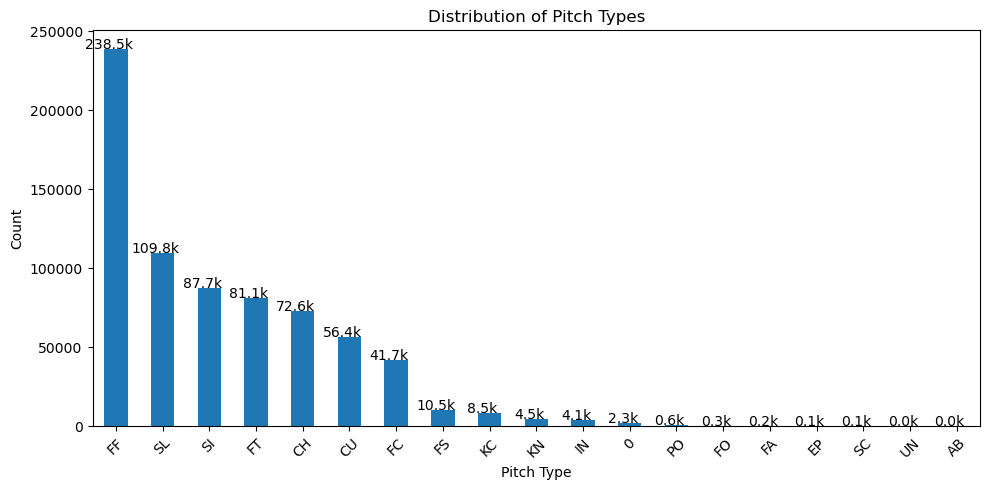

In [210]:
# Count the occurrences of each pitch type
pitch_type_counts = eda_df['pitch_type'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 5))
bars = pitch_type_counts.plot(kind='bar')
plt.title('Distribution of Pitch Types')
plt.xlabel('Pitch Type')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add rounded and formatted data labels on top of each bar
for bar, count in zip(bars.patches, pitch_type_counts):
    count_rounded = round(count / 1000, 1)  # Round to 1 decimal place and convert to thousands
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 5, f'{count_rounded}k', ha='center', fontsize=10)

plt.tight_layout()

# Show the plot
plt.show()

In [211]:
# Unsure what '0' means, so remove '0' and 'UN' (unknown) pitch types
eda_df = eda_df.drop(eda_df[(eda_df.pitch_type == 0) | (eda_df.pitch_type == 'UN')].index)

## pitches thrown by each pitcher

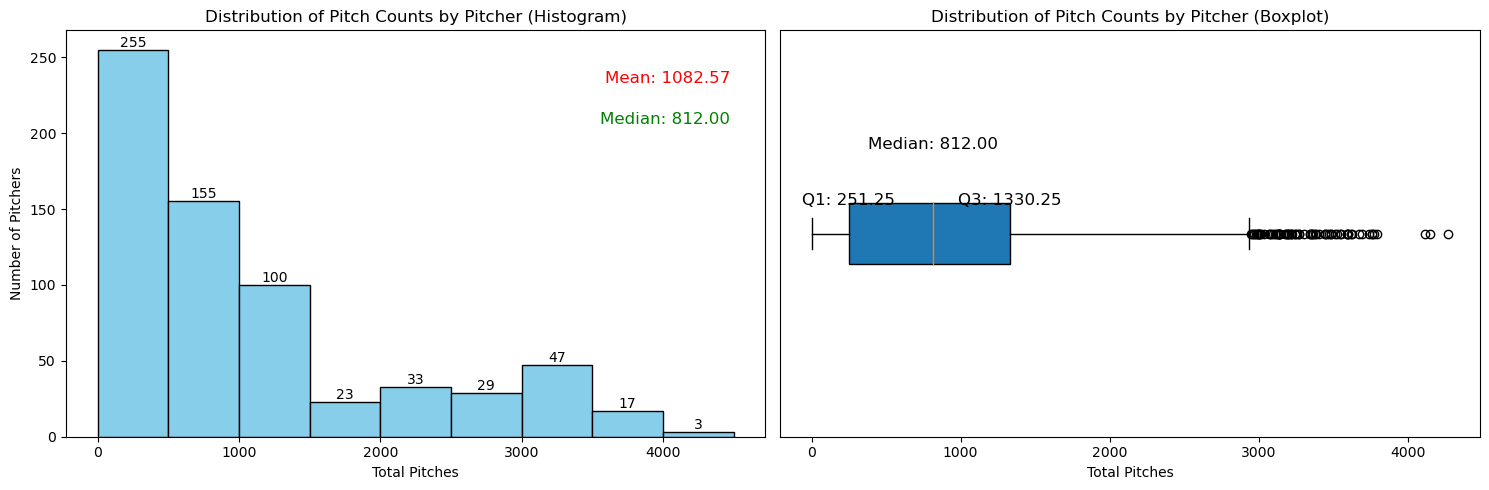

In [212]:
# Group the data by pitcher_id and calculate the total number of pitches for each pitcher
pitcher_pitch_counts = eda_df.groupby('pitcher_id')['pcount_pitcher'].count().reset_index()

# Rename the columns for clarity
pitcher_pitch_counts.columns = ['Pitcher ID', 'Total Pitches']

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the distribution of pitch counts as a histogram with data labels
bin_width = 500
bins = range(0, int(max(pitcher_pitch_counts['Total Pitches'])) + bin_width, bin_width)
n, _, _ = axes[0].hist(pitcher_pitch_counts['Total Pitches'], bins=bins, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Pitch Counts by Pitcher (Histogram)')
axes[0].set_xlabel('Total Pitches')
axes[0].set_ylabel('Number of Pitchers')

# Add data labels to the histogram bars
for i, count in enumerate(n):
    if count > 0:
        axes[0].text(bins[i] + bin_width / 2, count, str(int(count)), ha='center', va='bottom', fontsize=10)

# Calculate the mean and median
mean = pitcher_pitch_counts['Total Pitches'].mean()
median = pitcher_pitch_counts['Total Pitches'].median()

# Add mean and median labels to the top right of the histogram
axes[0].text(0.95, 0.9, f'Mean: {mean:.2f}', ha='right', va='top', color='red', transform=axes[0].transAxes, fontsize=12)
axes[0].text(0.95, 0.8, f'Median: {median:.2f}', ha='right', va='top', color='green', transform=axes[0].transAxes, fontsize=12)

# Create a boxplot to show the distribution of pitch counts
box = axes[1].boxplot([pitcher_pitch_counts['Total Pitches']], vert=False, patch_artist=True)
axes[1].set_title('Distribution of Pitch Counts by Pitcher (Boxplot)')
axes[1].set_xlabel('Total Pitches')
axes[1].set_yticks([])

# Calculate the median, Q1 (first quartile), and Q3 (third quartile) values
median = pitcher_pitch_counts['Total Pitches'].median()
q1 = pitcher_pitch_counts['Total Pitches'].quantile(0.25)
q3 = pitcher_pitch_counts['Total Pitches'].quantile(0.75)

# Label the median, Q1, and Q3 values on the boxplot
axes[1].text(median, 1.2, f'Median: {median:.2f}', ha='center', va='bottom', fontsize=12)
axes[1].text(q1, 1.1, f'Q1: {q1:.2f}', ha='center', va='top', fontsize=12)
axes[1].text(q3, 1.1, f'Q3: {q3:.2f}', ha='center', va='top', fontsize=12)

plt.tight_layout()

# Show the plot
plt.show()

In [213]:
# Drop pitchers who pitch less than 251 pitches

# Calculate the total pitch count for each pitcher
pitcher_counts = eda_df.groupby('pitcher_id')['pcount_pitcher'].count().reset_index()

# Filter for pitchers with less than 250 pitches
filtered_pitchers = pitcher_counts[pitcher_counts['pcount_pitcher'] < 250]

# Remove rows corresponding to pitchers with less than 250 pitches from the original dataset
eda_df = eda_df[~eda_df['pitcher_id'].isin(filtered_pitchers['pitcher_id'])]

## correlation matrix

In [214]:
# # VIF dataframe 
# vif_data = pd.DataFrame() 
# vif_data["feature"] = eda_df.columns 
  
# # calculating VIF for each feature 
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# vif_data["VIF"] = [variance_inflation_factor(eda_df.values, i)
#                           for i in range(len(eda_df.columns))]
  
# vif_data.sort_values(by='VIF', ascending=False).head(10)

In [215]:
# sns.heatmap(eda_df.corr())
# plt.show()

In [216]:
correlation_matrix = eda_df.corr()

# Convert the correlation matrix to a DataFrame
correlation_df = pd.DataFrame(correlation_matrix.stack(), columns=['Correlation'])

# Reset the index to have the feature pairs as separate rows
correlation_df.reset_index(level=0, inplace=True)
correlation_df.reset_index(level=0, inplace=True)

# Rename the columns for clarity
correlation_df.columns = ['Feature1', 'Feature2', 'Correlation']

# Sort by absolute correlation (greatest to smallest)
correlation_df['Absolute_Correlation'] = abs(correlation_df['Correlation'])
correlation_df = correlation_df.sort_values(by='Absolute_Correlation', ascending=False)

# Sort the columns so that swapped rows become identical
correlation_df[['Feature1', 'Feature2']] = np.sort(correlation_df[['Feature1', 'Feature2']], axis=1)

# Remove duplicates
correlation_df.drop_duplicates(inplace=True)
correlation_df = correlation_df[correlation_df['Feature1'] != correlation_df['Feature2']]

# Filter for rows where the correlation is greater than 0.7 or less than -0.7
filtered_data = correlation_df[correlation_df['Absolute_Correlation'] > 0.7]

# Display the DataFrame sorted by absolute correlation
print(filtered_data)

                 Feature1             Feature2  Correlation  \
214            at_bat_num               inning     0.976751   
740                 balls        pcount_at_bat     0.808504   
845         pcount_at_bat              strikes     0.788608   
8462  prev_1_pitch_typ...  prev_2_pitch_typ...     0.783725   
4369  prev_1_pitch_typ...        proportion_KN     0.761057   
1579           at_bat_num     starting_pitcher    -0.748330   
1577               inning     starting_pitcher    -0.722670   

      Absolute_Correlation  
214              0.976751   
740              0.808504   
845              0.788608   
8462             0.783725   
4369             0.761057   
1579             0.748330   
1577             0.722670   


In [217]:
eda_df.drop(['inning', 'pcount_at_bat'], axis=1, inplace=True)

# Modeling
## Model Selection

It's important to remember that we're building a multi-class probability model as opposed to a multi-class classification model.

We'll build and (attempt) to tune three models.
- Multinomial Logistic Regression
  - Multinomial logistic regression is an extension of binary logistic regression to multi-class problems. It models the probability of each class and uses the softmax function to convert raw scores into class probabilities.
- Random Forest
  - Random Forests can work well with imbalanced classes because they build multiple decision trees and can reduce the risk of overfitting to the majority class.
- Gradient Boosting
  - Gradient boosting algorithms are robust and can handle imbalanced data. They adaptively assign higher weights to misclassified samples, which can help in learning from minority classes.
  
There are other commonly used models for our purposes including Neural Networks, SVMs, and Naive Bayes. However, due to time constraints, lack of experience working with NN and SVMs, and that the chosen models perform well with imbalanced classes, the three models were _arbitraility_ chosen.

Also, from our EDA, there is a significant class imbalance, so it's important to address this while building our models. Below, are a few strategies for handling imbalanced data.
- Resampling
  - We can oversample the minority class, undersample the majority class, or use more advanced techniques like SMOTE (Synthetic Minority Over-sampling Technique) to balance the class distribution.
- Cost-sensitive Learning
  - Adjust the cost function to penalize misclassifications of the minority class more heavily.
- Ensemble Methods
  - Use ensemble techniques like EasyEnsemble or BalanceCascade to combine predictions from multiple models trained on balanced subsets of the data.
- Class Weighting **This is what we choose**
  - Assign higher weights to minority classes during model training to make the model more sensitive to those classes.
  


## Model Training

In [218]:
model_df = eda_df.copy()

In [219]:
print('Shape: {0}'.format(model_df.shape))

Shape: (695479, 109)


In [220]:
model_df.head()

,pitch_type,game_pk,game_number_for_pitcher,top,at_bat_num,pcount_pitcher,balls,strikes,fouls,outs,batter_id,batter_right_handed,batter_height_inches,pitcher_id,starting_pitcher,pitcher_right_handed,score_differential,is_first_base_occupied,is_second_base_occupied,is_third_base_occupied,pitcher_vs_batter_count,pitcher_ERA,strikeout_percentage,walk_percentage,whip_percentage,slugging_percentage,ob_percentage,proportion_SI,proportion_FF,proportion_SL,proportion_FC,proportion_CH,proportion_IN,proportion_0,proportion_PO,proportion_CU,proportion_FA,proportion_FT,proportion_UN,proportion_FS,proportion_KN,proportion_EP,proportion_AB,proportion_KC,proportion_FO,proportion_SC,prev_1_pitch_result_B,prev_1_pitch_result_S,prev_1_pitch_result_X,prev_2_pitch_result_B,prev_2_pitch_result_S,prev_2_pitch_result_X,prev_3_pitch_result_B,prev_3_pitch_result_S,prev_3_pitch_result_X,prev_1_pitch_type_AB,prev_1_pitch_type_CH,prev_1_pitch_type_CU,prev_1_pitch_type_EP,prev_1_pitch_type_FA,prev_1_pitch_type_FC,prev_1_pitch_type_FF,prev_1_pitch_type_FO,prev_1_pitch_type_FS,prev_1_pitch_type_FT,prev_1_pitch_type_IN,prev_1_pitch_type_KC,prev_1_pitch_type_KN,prev_1_pitch_type_PO,prev_1_pitch_type_SC,prev_1_pitch_type_SI,prev_1_pitch_type_SL,prev_1_pitch_type_UN,prev_2_pitch_type_AB,prev_2_pitch_type_CH,prev_2_pitch_type_CU,prev_2_pitch_type_EP,prev_2_pitch_type_FA,prev_2_pitch_type_FC,prev_2_pitch_type_FF,prev_2_pitch_type_FO,prev_2_pitch_type_FS,prev_2_pitch_type_FT,prev_2_pitch_type_IN,prev_2_pitch_type_KC,prev_2_pitch_type_KN,prev_2_pitch_type_PO,prev_2_pitch_type_SC,prev_2_pitch_type_SI,prev_2_pitch_type_SL,prev_2_pitch_type_UN,prev_3_pitch_type_AB,prev_3_pitch_type_CH,prev_3_pitch_type_CU,prev_3_pitch_type_EP,prev_3_pitch_type_FA,prev_3_pitch_type_FC,prev_3_pitch_type_FF,prev_3_pitch_type_FO,prev_3_pitch_type_FS,prev_3_pitch_type_FT,prev_3_pitch_type_IN,prev_3_pitch_type_KC,prev_3_pitch_type_KN,prev_3_pitch_type_PO,prev_3_pitch_type_SC,prev_3_pitch_type_SI,prev_3_pitch_type_SL,prev_3_pitch_type_UN
0,SI,286878,1,1,55,1,0,0,0,0,460026,1,73,110683,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,SI,286878,1,1,55,2,1,0,0,0,460026,1,73,110683,0,1,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,SI,286878,1,1,55,3,2,0,0,0,460026,1,73,110683,0,1,0,0,0,0,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,SI,286878,1,1,55,4,2,1,0,0,460026,1,73,110683,0,1,0,0,0,0,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,SI,286878,1,1,56,5,0,0,0,1,408305,1,75,110683,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [238]:
output = []

for col in model_df.columns:

    null = model_df[col].isnull().sum()
    unique = model_df[col].nunique()
    colType = str(model_df[col].dtype)

    output.append([col, null, unique, colType])

output = pd.DataFrame(output)   
output.columns = ['colName','null values', 'unique', 'dtype']
output

,colName,null values,unique,dtype
0,pitch_type,0,17,object
1,game_pk,0,2466,int64
2,game_number_for_...,0,89,int64
3,top,0,2,int64
4,at_bat_num,0,158,int64
5,pcount_pitcher,0,133,int64
6,balls,0,5,int64
7,strikes,0,3,int64
8,fouls,0,13,int64
9,outs,0,3,int64


In [222]:
y = model_df.pitch_type

# Convert pitch types to integer labels
# y_encoded = pd.get_dummies(y)

# Convert pitch types to integer labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [223]:
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [224]:
X = model_df.drop(['pitch_type', 'game_pk'], axis=1)

In [225]:
X.head()

,game_number_for_pitcher,top,at_bat_num,pcount_pitcher,balls,strikes,fouls,outs,batter_id,batter_right_handed,batter_height_inches,pitcher_id,starting_pitcher,pitcher_right_handed,score_differential,is_first_base_occupied,is_second_base_occupied,is_third_base_occupied,pitcher_vs_batter_count,pitcher_ERA,strikeout_percentage,walk_percentage,whip_percentage,slugging_percentage,ob_percentage,proportion_SI,proportion_FF,proportion_SL,proportion_FC,proportion_CH,proportion_IN,proportion_0,proportion_PO,proportion_CU,proportion_FA,proportion_FT,proportion_UN,proportion_FS,proportion_KN,proportion_EP,proportion_AB,proportion_KC,proportion_FO,proportion_SC,prev_1_pitch_result_B,prev_1_pitch_result_S,prev_1_pitch_result_X,prev_2_pitch_result_B,prev_2_pitch_result_S,prev_2_pitch_result_X,prev_3_pitch_result_B,prev_3_pitch_result_S,prev_3_pitch_result_X,prev_1_pitch_type_AB,prev_1_pitch_type_CH,prev_1_pitch_type_CU,prev_1_pitch_type_EP,prev_1_pitch_type_FA,prev_1_pitch_type_FC,prev_1_pitch_type_FF,prev_1_pitch_type_FO,prev_1_pitch_type_FS,prev_1_pitch_type_FT,prev_1_pitch_type_IN,prev_1_pitch_type_KC,prev_1_pitch_type_KN,prev_1_pitch_type_PO,prev_1_pitch_type_SC,prev_1_pitch_type_SI,prev_1_pitch_type_SL,prev_1_pitch_type_UN,prev_2_pitch_type_AB,prev_2_pitch_type_CH,prev_2_pitch_type_CU,prev_2_pitch_type_EP,prev_2_pitch_type_FA,prev_2_pitch_type_FC,prev_2_pitch_type_FF,prev_2_pitch_type_FO,prev_2_pitch_type_FS,prev_2_pitch_type_FT,prev_2_pitch_type_IN,prev_2_pitch_type_KC,prev_2_pitch_type_KN,prev_2_pitch_type_PO,prev_2_pitch_type_SC,prev_2_pitch_type_SI,prev_2_pitch_type_SL,prev_2_pitch_type_UN,prev_3_pitch_type_AB,prev_3_pitch_type_CH,prev_3_pitch_type_CU,prev_3_pitch_type_EP,prev_3_pitch_type_FA,prev_3_pitch_type_FC,prev_3_pitch_type_FF,prev_3_pitch_type_FO,prev_3_pitch_type_FS,prev_3_pitch_type_FT,prev_3_pitch_type_IN,prev_3_pitch_type_KC,prev_3_pitch_type_KN,prev_3_pitch_type_PO,prev_3_pitch_type_SC,prev_3_pitch_type_SI,prev_3_pitch_type_SL,prev_3_pitch_type_UN
0,1,1,55,1,0,0,0,0,460026,1,73,110683,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,55,2,1,0,0,0,460026,1,73,110683,0,1,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,55,3,2,0,0,0,460026,1,73,110683,0,1,0,0,0,0,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1,55,4,2,1,0,0,460026,1,73,110683,0,1,0,0,0,0,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1,1,56,5,0,0,0,1,408305,1,75,110683,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [230]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, brier_score_loss, roc_auc_score, auc, precision_recall_curve, mean_squared_error
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights to handle imbalanced data
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)

# Initialize models with class weighting
logistic_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight=dict(enumerate(class_weights)))
random_forest = RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced')
gradient_boosting = xgb.XGBClassifier(n_estimators=50, random_state=42)
# Future Work: grid search over a range of values and use cross-validation to find the optimal performance (i.e. model complexity and model performance)

# Define evaluation metrics
def evaluate_model(model, X, y, cv):
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    log_losses = []
    brier_scores = []
    auc_pr_scores = []
    mse_scores = []
    
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        unique_classes_train = np.unique(y_train)
        unique_classes_test = np.unique(y_test)
        # print("Unique classes in train:", unique_classes_train)
        # print("Unique classes in test:", unique_classes_test)

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)  # Get class probabilities

        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
        log_losses.append(log_loss(y_test, y_prob))

        # Calculate Brier Score for each class separately
        for class_idx in np.unique(y):
            brier_scores.append(brier_score_loss((y_test == class_idx).astype(int), y_prob[:, class_idx]))

        # Calculate AUC-PR for each class separately
        auc_pr_class_scores = []
        for class_idx in np.unique(y):
            precision, recall, _ = precision_recall_curve((y_test == class_idx).astype(int), y_prob[:, class_idx])
            auc_pr_class_scores.append(auc(recall, precision))
        auc_pr_scores.append(np.mean(auc_pr_class_scores))

        # Calculate MSE for each class separately
        mse_class_scores = []
        for class_idx in np.unique(y):
            mse_class_scores.append(mean_squared_error((y_test == class_idx).astype(int), y_prob[:, class_idx]))
        mse_scores.append(np.mean(mse_class_scores))

    return {
        'Accuracy': np.mean(accuracy_scores),
        'Precision': np.mean(precision_scores),
        'Recall': np.mean(recall_scores),
        'F1 Score': np.mean(f1_scores),
        
        'Log Loss': np.mean(log_losses),
        'Brier Score': np.mean(brier_scores),
        'AUC-PR': np.mean(auc_pr_scores),
        'MSE': np.mean(mse_scores)
    }
       

# Stratified cross-validation with explicit class labels
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
# Future Work: grid search over a range of values (5-10) to find a balance between bias and variance.

# Evaluate models
logistic_reg_metrics = evaluate_model(logistic_reg, X, y, cv)
random_forest_metrics = evaluate_model(random_forest, X, y, cv)
gradient_boosting_metrics = evaluate_model(gradient_boosting, X, y, cv)

# Print evaluation metrics
print("Multinomial Logistic Regression Metrics with Class Weighting:")
print(logistic_reg_metrics)

print("\nRandom Forest Metrics with Class Weighting:")
print(random_forest_metrics)

print("\nGradient Boosting Metrics:")
print(gradient_boosting_metrics)

Multinomial Logistic Regression Metrics with Class Weighting:
{'Accuracy': 0.031849952824918926, 'Precision': 0.10527886301088071, 'Recall': 0.031849952824918926, 'F1 Score': 0.023114914313103797, 'Log Loss': 2.782797275888477, 'Brier Score': 0.05646186391414326, 'AUC-PR': 0.06623401768615775, 'MSE': 0.056461863914143255}

Random Forest Metrics with Class Weighting:
{'Accuracy': 0.47588352727909694, 'Precision': 0.44822777293466187, 'Recall': 0.47588352727909694, 'F1 Score': 0.447733165144648, 'Log Loss': 1.4603498800776196, 'Brier Score': 0.03776152176892463, 'AUC-PR': 0.35199738529587976, 'MSE': 0.037761521768924625}

Gradient Boosting Metrics:
{'Accuracy': 0.4970861800341976, 'Precision': 0.4757439453382631, 'Recall': 0.4970861800341976, 'F1 Score': 0.46389261844425844, 'Log Loss': 1.1784545776687554, 'Brier Score': 0.036375685526193226, 'AUC-PR': 0.38041732747826673, 'MSE': 0.03637568552619322}


## Model Evaluation

We will use stratified cross-validation and calculate evaluation metrics suitable for imbalanced datasets.

- Log Loss (Logarithmic Loss):
  - Log Loss measures the accuracy of predicted probabilities. It quantifies how well the predicted probabilities match the true probabilities.
  - Lower log loss values indicate better predictions, with 0 indicating perfect predictions.
- Brier Score (Mean Squared Error Loss):
  - Brier Score measures the mean squared difference between predicted probabilities and true binary outcomes.
  - Lower Brier Score values indicate better predictions, with 0 indicating perfect predictions.
- Area Under the Precision-Recall Curve (AUC-PR):
  - AUC-PR measures the ability of the model to rank positive examples higher than negative examples.
  - Higher AUC-PR values indicate better predictive performance, especially for imbalanced datasets.
- Mean Squared Error (MSE):
  - MSE measures the mean squared difference between predicted probabilities and true probabilities for regression-type problems.
  - Lower MSE values indicate better predictions.

### Key Takeaways

- Multinomial Logistic Regression:
  - Accuracy: Very low (approximately 3.2%)
  - Precision: Low (approximately 10.5%)
  - Recall: Very low (approximately 3.2%)
  - F1 Score: Very low (approximately 2.3%)
  - Log Loss: High (approximately 2.78)
  - Brier Score: High (approximately 0.056)
  - AUC-PR: Very low (approximately 0.066) 
  - MSE: High (approximately 0.056)
- Random Forest: 
  - Accuracy: Moderate (approximately 47.6%)
  - Precision: Moderate (approximately 44.8%) 
  - Recall: Moderate (approximately 47.6%) 
  - F1 Score: Moderate (approximately 44.8%) 
  - Log Loss: Moderate (approximately 1.46) 
  - Brier Score: Moderate (approximately 0.038) 
  - AUC-PR: Low to moderate (approximately 0.352) 
  - MSE: Moderate (approximately 0.038) 
- Gradient Boosting: 
  - Accuracy: Moderate (approximately 49.7%)
  - Precision: Moderate (approximately 47.6%) 
  - Recall: Moderate (approximately 49.7%) 
  - F1 Score: Moderate (approximately 46.4%) 
  - Log Loss: Moderate (approximately 1.18) 
  - Brier Score: Moderate (approximately 0.036) 
  - AUC-PR: Low to moderate (approximately 0.380) 
  - MSE: Moderate (approximately 0.036) 
- Summary
  - Accuracy: All models have relatively low accuracy, but Gradient Boosting performs slightly better than the others in this regard. 
  - Precision and Recall: Random Forest and Gradient Boosting have higher precision and recall compared to Logistic Regression, indicating better overall predictive power. 
  - Log Loss: Gradient Boosting has the lowest log loss, suggesting that it provides more calibrated probability estimates. 
  - Brier Score: Gradient Boosting and Random Forest have lower Brier Scores, indicating better-calibrated probabilistic predictions compared to Logistic Regression. 
  - AUC-PR: Gradient Boosting and Random Forest outperform Logistic Regression in terms of AUC-PR, which measures the trade-off between precision and recall. 
  - MSE: All models have moderate MSE values, but Gradient Boosting has the lowest MSE, suggesting better overall prediction accuracy. 
  - **Given these considerations, Gradient Boosting appears to be the best-performing model among the three. It offers a good balance between precision and recall, has lower log loss and Brier Score, and performs well in terms of AUC-PR. However, it's essential to note that the absolute performance metrics are relatively low, indicating that further model improvement or feature engineering may be needed to achieve higher accuracy and precision.**

## Model Interpretation

Determine which features in our dataset were significant in predicting pitch type.
- Logistic Regression:
  - For logistic regression, we analyze the coefficients of the model. The magnitude (absolute value) of the coefficients can indicate the importance of the corresponding features. Larger magnitude coefficients suggest more significant features.

In [231]:
# Fit the logistic regression model
# logistic_reg.fit(X, y)

# Create a DataFrame to store feature names and their coefficients
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': logistic_reg.coef_[0]})

# Sort the features by coefficient magnitude (absolute value)
feature_importance_df['Coefficient_abs'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values(by='Coefficient_abs', ascending=False).drop(columns='Coefficient_abs')

# Print the top features and their coefficients
print(feature_importance_df.head(10))

                Feature   Coefficient
11           pitcher_id -2.145037e-04
8             batter_id  6.196624e-05
18  pitcher_vs_batte...  8.222090e-08
3        pcount_pitcher  7.979542e-08
10  batter_height_in... -3.655922e-08
2            at_bat_num -2.195051e-08
0   game_number_for_... -2.104510e-08
19          pitcher_ERA -1.110317e-08
6                 fouls  4.828339e-09
13  pitcher_right_ha... -3.061293e-09


- Random Forest and Gradient Boosting
  - These models assign an importance score to each feature based on how much they contribute to reducing error.

In [233]:
# Fit the random forest
# random_forest.fit(X, y)

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': random_forest.feature_importances_})

# Sort the features by importance score
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top features and their importance scores
print(feature_importance_df.head(10))

                Feature  Importance
0   game_number_for_...         0.0
80  prev_2_pitch_typ...         0.0
78  prev_2_pitch_typ...         0.0
77  prev_2_pitch_typ...         0.0
76  prev_2_pitch_typ...         0.0
75  prev_2_pitch_typ...         0.0
74  prev_2_pitch_typ...         0.0
73  prev_2_pitch_typ...         0.0
72  prev_2_pitch_typ...         0.0
71  prev_2_pitch_typ...         0.0


In [234]:
# Fit the random forest
# gradient_boosting.fit(X, y)

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': gradient_boosting.feature_importances_})

# Sort the features by importance score
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top features and their importance scores
print(feature_importance_df.head(10))

                Feature  Importance
63  prev_1_pitch_typ...    0.166112
25        proportion_SI    0.130768
38        proportion_KN    0.074435
35        proportion_FT    0.062026
28        proportion_FC    0.058380
26        proportion_FF    0.044617
41        proportion_KC    0.036941
37        proportion_FS    0.034806
27        proportion_SL    0.034425
13  pitcher_right_ha...    0.029655


- Permutation Importance:
  - In addition to the built-in feature importances, we can also use permutation importance. Permutation importance evaluates feature importance by permuting the values of a single feature and measuring the change in model performance (e.g., accuracy or log loss). Features that, when permuted, result in a significant drop in performance are considered more important.

In [235]:
# from sklearn.inspection import permutation_importance

# # Fit the model
# model.fit(X, y)

# # Calculate permutation importance
# perm_importance = permutation_importance(model, X, y_int, n_repeats=30, random_state=42)

# # Get feature importances
# feature_importances = perm_importance.importances_mean

# # Identify significant features by importance score
# significant_f = X.columns[feature_importances > threshold]

### Key Takeaways

- The most important features for the Regression model tend to be more focussed on the pitcher-batter matchup (i.e. batter_id and the # of pitches thrown so far).
- However, both the Random Forest and Gradient Boost models place importance on what the proportion of pitches have been thrown so far for each pitcher.
- **It would be interesting to see how a naive model that predicts the next pitch based on what the pitcher has thrown most often compares to these more scientific approaches.**

# Future Work

As a first version, we have a laid a good foundation in terms of engineered features and model selection. However, we are not close to a point where we can be confident in our probabilities/predictions.

I spent most of my time researching/engineering features rather than model tuning because higher quality features tend to have a more significant improvement in performance more than tuning (i.e. garbage in, garbage out). Of course, it's not a matter of one being more important than the other, instead, they complement each other. The best process is iterative where we started with a few engineered features and tested a handful of models. Moving forward, we can experiment and iterate with
- more seasons of data
- different features
  - advanced stats
- feature selection
  - bias/variance tradeoff
- handling imbalance of classes
  - resampling, etc.
- model tuning and/or different models
  - estimators and k-folds


## future features
### game
- stadium effects
  - wind, humidity, altitude, playing surface.
### at-bat
- catcher's signals
  - catchers may give subtle hints about the next pitch, such as setting up inside for a fastball.
- pitcher's historical averages
  - historical averages for pitch selection in specific counts or situations providing a baseline for predicting the most likely pitch.
### batter
- batting order
  - batter's will be ordered by their strengths.
- batter's batting avg against pitcher
  - average batting % for each combination of pitcher and type.
  - probably don't have enough data to make it useful.
- batter's heatmaps
  - identify batter's hot zones (strengths) and cold zones (weaknesses) within the strike zone.
  - e.g. if a pitcher knows a batter's hot zones, they'll be more inclined to pitch to cold zones.
### pitcher
- height
- grip
  - different pitches require different grip variations.
- pitcher's performance
  - calculating moving average of metrics over different windows of time.
- pitcher's injury and fatigue
  - pitchers may perform differently based on their physical condition, which can change over time.
- pitch location clustering
  - pitchers have preferred locations within the strike zone.
  - e.g. a pitcher may cluster pitches low and away for right-handed batters or high and inside for left-handed batters.

## future work
- Multi-Class Classification is difficult when there is a large imbalance. Instead, we could try to predict the group of pitch.
    - Fastballs: Four-seam, Two-seam, Cutter, Splitter, and Forkball
    - Breaking Balls: Curveball, Slider, Slurve, and Screwball
    - Changeups: Changeup, Palmball, Circle Changeup